# Mapping the phase space of a jet


## 1-D Unfolding  of $\tau_{1}^{(\beta)}$ measured with $E$-scheme recombination, with a purity&stability study for each observables' binning


#### Firstly , import the ROOT data analysis framework which will be used to read the data files and unfold the final result. 

In [1]:
import ROOT
import array as array
from array import array
import os
import glob
from ROOT import TH1D, TH2D, TTree,TFile, TObject, TCanvas, TGraph, TH1F, TH2F, TMath
from random import gauss
import numpy as np
import root_numpy as rtnpy
from root_numpy import *
import h5py
from awkward import JaggedArray, Table
import matplotlib.pyplot as plt
import seaborn as sns



Welcome to JupyROOT 6.18/00


In [2]:
#!/usr/bin/env python
import argparse, os, shutil, sys
from datasets import *
from array import array
import numpy as np
from DrawHistogram import plotSimpleComparison
#sys.path.insert(0,'../python/')
import CMS_lumi as CMS_lumi
import tdrstyle as tdrStyle
####gReset()
ROOT.gROOT.SetBatch()
ROOT.gROOT.ForceStyle()
tdrStyle.setTDRStyle()
ROOT.gStyle.SetOptStat(0)
ROOT.TH1.SetDefaultSumw2()


/shome/kdatta/miniconda3/envs/python2/lib/python2.7/site-packages/ROOT.py:649: UserWarning: "from ROOT import *" is not supported under IPython
  warnings.warn( '"from ROOT import *" is not supported under IPython' )


In [3]:
#%jsroot on

In [4]:
def loadHistograms( samples, variables, sel, sysUnc=[], isMC=True ):
    """docstring for loadHistograms"""

    SYSUNC = [ '_nom' ] + [ s+u for u in ['Down', 'Up'] for s in sysUnc ]
    
    allHistos = {}
    for var in variables:
        for isam in samples:
            tmpList = [ 'recoJet'+var+syst+sel for syst in SYSUNC ]
            if isMC: tmpList = tmpList + [ 'genJet'+var+sel ] + [ 'respJet'+var+syst+sel for syst in SYSUNC ]
            for ih in tmpList:
                #print var, isam, ih
                allHistos[isam+'_'+ih] = samples[isam][0].Get( 'jetObservables/'+ih )
                
                if isMC:
                    tmpIsam = 'TT' if isam.startswith('data') else isam
                    MCScale = checkDict( tmpIsam, dictSamples )['XS'] * lumi / checkDict( tmpIsam, dictSamples )['2016']['nGenWeights']
                    allHistos[isam+'_'+ih].Scale( MCScale )
                
                if not ih.startswith('resp'):
                    if len(variables[var])==1:
                        if ih.startswith('reco'):
                            #allHistos[isam+'_'+ih].SetDirectory(0)
                            allHistos[isam+'_'+ih+'_genBin'] = allHistos[isam+'_'+ih].Clone()
                            allHistos[isam+'_'+ih+'_genBin'].Rebin( variables[var][0] )
                            allHistos[isam+'_'+ih].Rebin( int(variables[var][0]/2.) )
                        else: allHistos[isam+'_'+ih].Rebin( variables[var][0] )
                        #print ih, variables[var][0]
                    else:
                        if ih.startswith('reco'):
                            newRecoBins = array('d',[])#np.empty(2*variables[var].shape[0]-1)#np.array(sorted([ np.round((variables[var][i]+variables[var][i+1])/2.,3) for i in range(len(variables[var])-1) ] + variables[var]))
                            for i in xrange(0,len(variables[var])-1):
                                #print (variables[var][i]+variables[var][i+1])/2., variables[var][i], variables[var][i+1]
                                newRecoBins.append(np.round((variables[var][i]+variables[var][i+1])/2.,3))
                            
                            #print newRecoBins, variables[var]    
                            #newRecoBins = np.concatenate((newRecoBins,variables[var]))
                            #newRecoBins = np.sort(newRecoBins)
                            newRecoBins.extend(variables[var])
                            newRecoBins = array('d', sorted(newRecoBins))
                            print "New variable bins:", newRecoBins, ih, variables[var]
                            allHistos[isam+'_'+ih+'_genBin'] = allHistos[isam+'_'+ih].Clone()
                            allHistos[isam+'_'+ih+'_genBin'] = allHistos[isam+'_'+ih+'_genBin'].Rebin(len(variables[var])-1, allHistos[isam+'_'+ih].GetName()+"_Rebin_genBin", array( 'd', variables[var])); 
                            #allHistos[isam+'_'+ih+'_genBin'].SetDirectory(0)
                            #allHistos[isam+'_'+ih].SetDirectory(0)
                            allHistos[isam+'_'+ih] = allHistos[isam+'_'+ih].Rebin( len(newRecoBins)-1, allHistos[isam+'_'+ih].GetName()+"_Rebin", array( 'd', newRecoBins ) )
                            #allHistos[isam+'_'+ih].SetDirectory(0)
                        else:
                            #print ih,  len(variables[var])-1, allHistos[isam+'_'+ih].GetName()+"_Rebin", array( 'd', variables[var])
                            allHistos[isam+'_'+ih] = allHistos[isam+'_'+ih].Rebin( len(variables[var])-1, allHistos[isam+'_'+ih].GetName()+"_Rebin", array( 'd', variables[var] ) )
                            #allHistos[isam+'_'+ih].SetDirectory(0)
                else:
                    if len(variables[var])==1: allHistos[isam+'_'+ih].Rebin2D( variables[var][0], int(variables[var][0]/2.) )
                    else:
                        #newRecoBins = sorted([ (variables[var][i]+variables[var][i+1])/2. for i in range(len(variables[var])-1) ] + variables[var])
                        newRecoBins = array('d',[])#np.empty(2*variables[var].shape[0]-1)#np.array(sorted([ np.round((variables[var][i]+variables[var][i+1])/2.,3) for i in range(len(variables[var])-1) ] + variables[var]))
                        for i in xrange(0,len(variables[var])-1):
                            #print (variables[var][i]+variables[var][i+1])/2., variables[var][i], variables[var][i+1]
                            newRecoBins.append(np.round((variables[var][i]+variables[var][i+1])/2.,3))

                        #print newRecoBins, variables[var]    
                        #newRecoBins = np.concatenate((newRecoBins,variables[var]))
                        #newRecoBins = np.sort(newRecoBins)
                        newRecoBins.extend(variables[var])
                        newRecoBins = sorted(newRecoBins)
                        print "New variable bins TH2F:", newRecoBins
                        #### fancy way to create variable binning TH2D
                        tmpHisto = TH2F( allHistos[isam+'_'+ih].GetName()+isam+"_Rebin", allHistos[isam+'_'+ih].GetName()+isam+"_Rebin", len(variables[var])-1, array( 'd', variables[var]), len(newRecoBins)-1, array( 'd', newRecoBins) )

                        tmpArrayContent = np.zeros((len(variables[var]), len(newRecoBins)))
                        tmpArrayError = np.zeros((len(variables[var]), len(newRecoBins)))

                        xaxis = allHistos[isam+'_'+ih].GetXaxis() 
                        yaxis = allHistos[isam+'_'+ih].GetYaxis()
                        
                        for j in range(1, yaxis.GetNbins()+1):
                            for i in range(1, xaxis.GetNbins()+1): 
                                tmpHisto.Fill(xaxis.GetBinCenter(i),yaxis.GetBinCenter(j),allHistos[isam+'_'+ih].GetBinContent(i,j)) 

                        allHistos[isam+'_'+ih] = tmpHisto
                        #allHistos[isam+'_'+ih].SetDirectory(0)
                
                    ##### For tests, projections directly from 2D
                    #allHistos[isam+'_genJetfrom_'+ih] = allHistos[isam+'_'+ih].ProjectionY()
                    #allHistos[isam+'_genJetfrom_'+ih].SetDirectory(0)
                    #allHistos[isam+'_recoJetfrom_'+ih] = allHistos[isam+'_'+ih].ProjectionX()
                    #allHistos[isam+'_recoJetfrom_'+ih].SetDirectory(0)
                    
                allHistos[isam+'_'+ih+'_Normalized'] = allHistos[isam+'_'+ih].Clone()
                #allHistos[isam+'_'+ih+'_Normalized'].SetDirectory(0)
                try: allHistos[isam+'_'+ih+'_Normalized'].Scale( 1/allHistos[isam+'_'+ih+'_Normalized'].Integral() )
                except ZeroDivisionError: continue
                    
                histos=allHistos.copy()
            #samples[isam][0].Close()
    return histos


In [5]:
ROOT.TH1.SetDefaultSumw2()


#### Below the MC and Data events are read from ROOT trees which only contain events meeting the selection criteria set forth in this __[script](https://github.com/kaustuvdatta/jetObservables/blob/102X/python/nSubProducer_gen_reco.py)__ and thereafter in the nSubExtractor class

In [6]:
lumi=35920

In [7]:
variables = {}
#variables[ '_tau_0p5_0' ] = array('d', [0., 0.2, 0.26, 0.32, 0.38, 0.44,  0.5, 0.56, 0.62, 0.68, 0.74, 0.8, 0.9    ])
#variables[ '_tau_1_0' ] = array('d',[0., 0.1, 0.16, 0.22, 0.28, 0.34, 0.4, 0.46, 0.52, 0.58, 0.64, 0.8])#[0. 0.25 0.30625 0.3625 0.418750.475 0.53125 0.5875 0.64375 0.7 0.8 ][0., 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.65]#[ 6]
#variables[ '_tau_2_0' ] = [ 3]
#variables[ '_tau_0p5_1' ] =  array('d', [0., 0.1, 0.16, 0.22, 0.28, 0.34,  0.42, 0.5, 0.58, 0.7, 0.8    ])#[5] #gen_bins2  ### (reco,gen)
#variables[ '_tau_1_1' ] = [ 8]
#variables[ '_tau_2_1' ] = [ 5]
#variables[ '_tau_0p5_2' ] = array('d', [0., 0.0, 0.12, 0.18, 0.24, 0.3, 0.36, 0.42, 0.5, 0.6])# [5] #gen_bins2  ### (reco,gen)
#variables[ '_tau_1_2' ] = [ 5]
#variables[ '_tau_2_2' ] = [ 4]

variables[ '_tau_0p5_3' ] = array('d',[0., 0.08, 0.14, 0.2, 0.26, 0.32, 0.38, 0.46])#[8] #gen_bins2  ### (reco,gen)
#variables[ '_tau_1_3' ] = [ 5]
#variables[ '_tau_2_3' ] = [0., 0.006, 0.012, 0.018, 0.024, 0.03, 0.04, 0.055, 0.075, 0.11] #[4]#[0., 0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.0225, 0.025]

sysUncert = [ '_jesTotal', '_jer', '_pu' ]
print variables

{'_tau_0p5_3': array('d', [0.0, 0.08, 0.14, 0.2, 0.26, 0.32, 0.38, 0.46])}


In [8]:
sel= '_topSel'
process = 'data'
version = 'v01_fin'

In [9]:
dataFile = {}
dataFile['data'] = [ TFile('Histos_SysUnc/jetObservables_histograms_SingleMuonRun2016ALL.root' ), 'Data', 'kBlack' ]

In [10]:
sigFiles = {}
sigFiles['TT'] = [ TFile('Histos_SysUnc/jetObservables_histograms_TT_TuneCUETP8M2T4_13TeV-powheg-pythia8.root'), 'ttbar (powheg)', 'kRed' ]
#sigFiles['TTJets'] = [ TFile('Histos_SysUnc/jetObservables_histograms_TTJets_TuneCUETP8M1_13TeV-madgraphMLM-pythia8.root'), 'ttbar (MG)', 'kBlue' ]

In [11]:
bkgFiles = {}
bkgFiles['ST_s-channel_4f_InclusiveDecays'] = [ TFile('Histos_SysUnc/jetObservables_histograms_ST_s-channel_4f_InclusiveDecays_13TeV-amcatnlo-pythia8.root' ), 'Single top', 'kMagenta' ]
bkgFiles['ST_t-channel_antitop'] = [ TFile('Histos_SysUnc/jetObservables_histograms_ST_t-channel_antitop_4f_inclusiveDecays_13TeV-powhegV2-madspin-pythia8_TuneCUETP8M1.root' ), 'Single top', 'kMagenta' ]
bkgFiles['ST_t-channel_top'] = [ TFile('Histos_SysUnc/jetObservables_histograms_ST_t-channel_top_4f_inclusiveDecays_13TeV-powhegV2-madspin-pythia8_TuneCUETP8M1.root' ), 'Single top', 'kMagenta' ]
bkgFiles['ST_tW_antitop'] = [ TFile('Histos_SysUnc/jetObservables_histograms_ST_tW_antitop_5f_inclusiveDecays_13TeV-powheg-pythia8_TuneCUETP8M2T4.root' ), 'Single top', 'kMagenta' ]
bkgFiles['ST_tW_top'] = [ TFile('Histos_SysUnc/jetObservables_histograms_ST_tW_top_5f_inclusiveDecays_13TeV-powheg-pythia8_TuneCUETP8M2T4.root' ), 'Single top', 'kMagenta' ]
#bkgFiles['WJets'] = [ TFile( inputFolder+'/jetObservables_histograms_WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8.root' ), 'WJets', 'kCyan' ]
###bkgFiles[] = [ '', TFile( inputFolder+'/jetObservables_histograms_'+ibkg+'.root' ), '', 'kMagenta' ]

In [12]:
dataHistos = loadHistograms( dataFile, variables, sel='_topSel', isMC=False )
signalHistos = loadHistograms( sigFiles, variables, sel='_topSel', sysUnc=sysUncert )
bkgHistos = loadHistograms( bkgFiles, variables, sel='_topSel', sysUnc=sysUncert ) 

New variable bins: array('d', [0.0, 0.04, 0.08, 0.11, 0.14, 0.17, 0.2, 0.23, 0.26, 0.29, 0.32, 0.35, 0.38, 0.42, 0.46]) recoJet_tau_0p5_3_nom_topSel array('d', [0.0, 0.08, 0.14, 0.2, 0.26, 0.32, 0.38, 0.46])
New variable bins: array('d', [0.0, 0.04, 0.08, 0.11, 0.14, 0.17, 0.2, 0.23, 0.26, 0.29, 0.32, 0.35, 0.38, 0.42, 0.46]) recoJet_tau_0p5_3_nom_topSel array('d', [0.0, 0.08, 0.14, 0.2, 0.26, 0.32, 0.38, 0.46])
New variable bins: array('d', [0.0, 0.04, 0.08, 0.11, 0.14, 0.17, 0.2, 0.23, 0.26, 0.29, 0.32, 0.35, 0.38, 0.42, 0.46]) recoJet_tau_0p5_3_jesTotalDown_topSel array('d', [0.0, 0.08, 0.14, 0.2, 0.26, 0.32, 0.38, 0.46])
New variable bins: array('d', [0.0, 0.04, 0.08, 0.11, 0.14, 0.17, 0.2, 0.23, 0.26, 0.29, 0.32, 0.35, 0.38, 0.42, 0.46]) recoJet_tau_0p5_3_jerDown_topSel array('d', [0.0, 0.08, 0.14, 0.2, 0.26, 0.32, 0.38, 0.46])
New variable bins: array('d', [0.0, 0.04, 0.08, 0.11, 0.14, 0.17, 0.2, 0.23, 0.26, 0.29, 0.32, 0.35, 0.38, 0.42, 0.46]) recoJet_tau_0p5_3_puDown_topSel arr

New variable bins: array('d', [0.0, 0.04, 0.08, 0.11, 0.14, 0.17, 0.2, 0.23, 0.26, 0.29, 0.32, 0.35, 0.38, 0.42, 0.46]) recoJet_tau_0p5_3_puDown_topSel array('d', [0.0, 0.08, 0.14, 0.2, 0.26, 0.32, 0.38, 0.46])
New variable bins: array('d', [0.0, 0.04, 0.08, 0.11, 0.14, 0.17, 0.2, 0.23, 0.26, 0.29, 0.32, 0.35, 0.38, 0.42, 0.46]) recoJet_tau_0p5_3_jesTotalUp_topSel array('d', [0.0, 0.08, 0.14, 0.2, 0.26, 0.32, 0.38, 0.46])
New variable bins: array('d', [0.0, 0.04, 0.08, 0.11, 0.14, 0.17, 0.2, 0.23, 0.26, 0.29, 0.32, 0.35, 0.38, 0.42, 0.46]) recoJet_tau_0p5_3_jerUp_topSel array('d', [0.0, 0.08, 0.14, 0.2, 0.26, 0.32, 0.38, 0.46])
New variable bins: array('d', [0.0, 0.04, 0.08, 0.11, 0.14, 0.17, 0.2, 0.23, 0.26, 0.29, 0.32, 0.35, 0.38, 0.42, 0.46]) recoJet_tau_0p5_3_puUp_topSel array('d', [0.0, 0.08, 0.14, 0.2, 0.26, 0.32, 0.38, 0.46])
New variable bins TH2F: [0.0, 0.04, 0.08, 0.11, 0.14, 0.17, 0.2, 0.23, 0.26, 0.29, 0.32, 0.35, 0.38, 0.42, 0.46]
New variable bins TH2F: [0.0, 0.04, 0.08, 

|------> Unfolding _tau_0p5_3
|------> Cross check: plotting data vs all MC
('Processing.......', '_tau_0p5_3_fromData_TT_nom_dataallBkgs_simpleComparisonPlot_topSel_v01_fin.png')
('Processing.......', '_tau_0p5_3_fromData_TT_nom_Normalized_dataallBkgs_simpleComparisonPlot_topSel_v01_fin.png')
|------> Cross check: plotting response matrix for signal
35.92 fb^{-1}, 2016 (13 TeV)
35.92 fb^{-1}, 2016 (13 TeV)
|------> TUnfolding starts:
|------> TUnfolding adding input:
|------> TUnfolding adding uncert:
_jesTotalUp
35.92 fb^{-1}, 2016 (13 TeV)
_jesTotalDown
35.92 fb^{-1}, 2016 (13 TeV)
_jerUp
35.92 fb^{-1}, 2016 (13 TeV)
_jerDown
35.92 fb^{-1}, 2016 (13 TeV)
_puUp
35.92 fb^{-1}, 2016 (13 TeV)
_puDown
35.92 fb^{-1}, 2016 (13 TeV)
|------> TUnfolding doUnfold:
|------> TUnfolding covariances
|------> TUnfolding uncertainties:
_jesTotalUp
_jesTotalDown
_jerUp
_jerDown
_puUp
_puDown
13 TeV, 2016 (13 TeV)
35.92 fb^{-1}, 2016 (13 TeV)


Info in <TCanvas::Print>: png file Plots/_tau_0p5_3_fromData_TT_nom_dataallBkgs_simpleComparisonPlot_topSel_v01_fin.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file Plots/_tau_0p5_3_fromData_TT_nom_Normalized_dataallBkgs_simpleComparisonPlot_topSel_v01_fin.png has been created
Info in <TCanvas::Print>: png file Plots/_tau_0p5_3_fromData_TT_topSel_responseMatrixv01_fin.png has been created
Info in <TCanvas::Print>: png file Plots/_tau_0p5_3_fromData_TT_topSelNormalized_responseMatrixv01_fin.png has been created
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 14 input bins and 7 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #8 (xaxis:[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xa

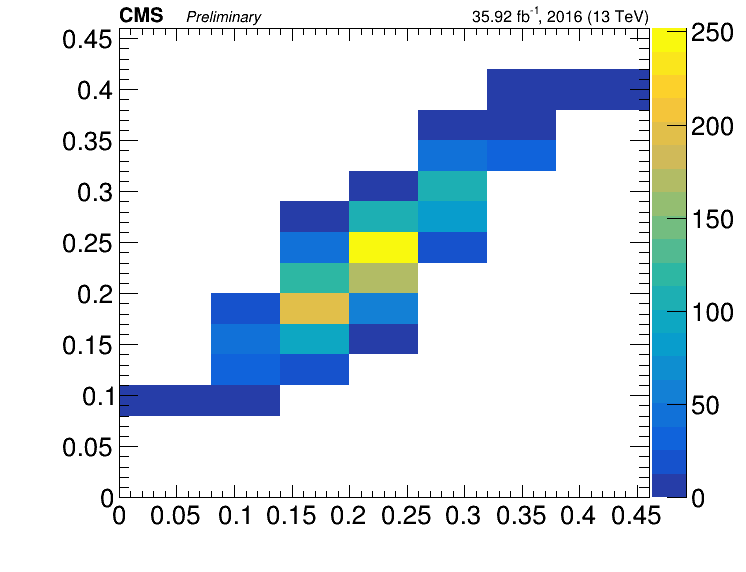

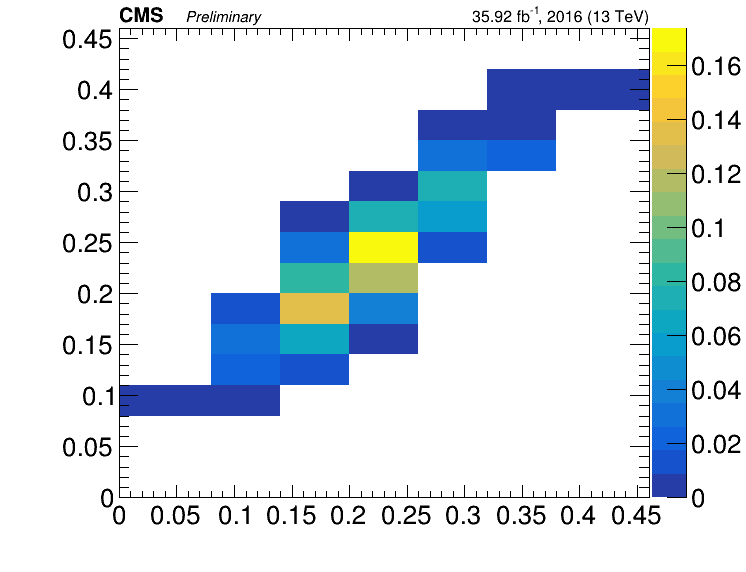

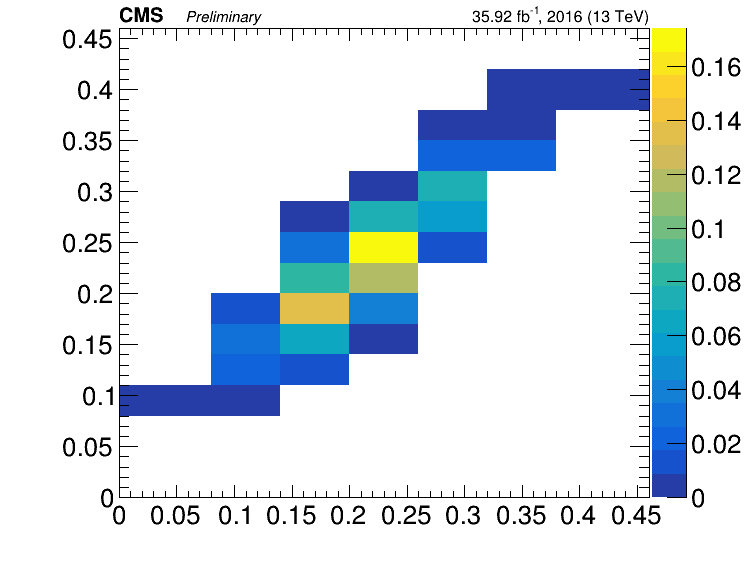

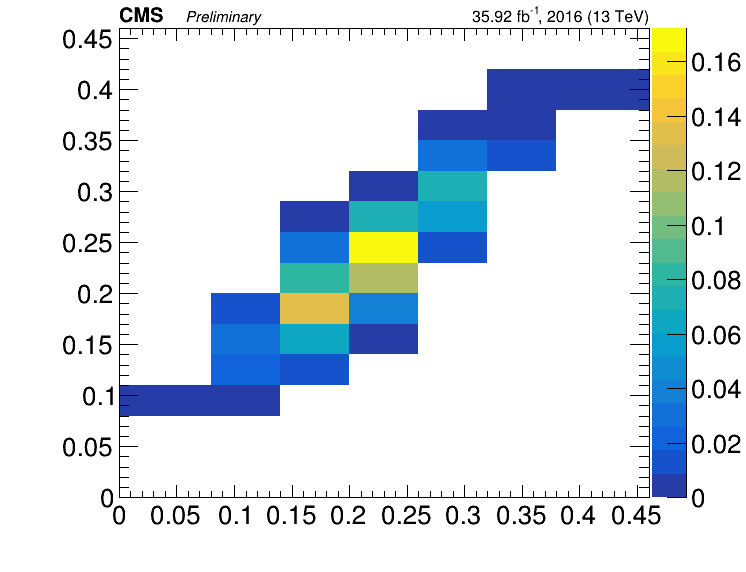

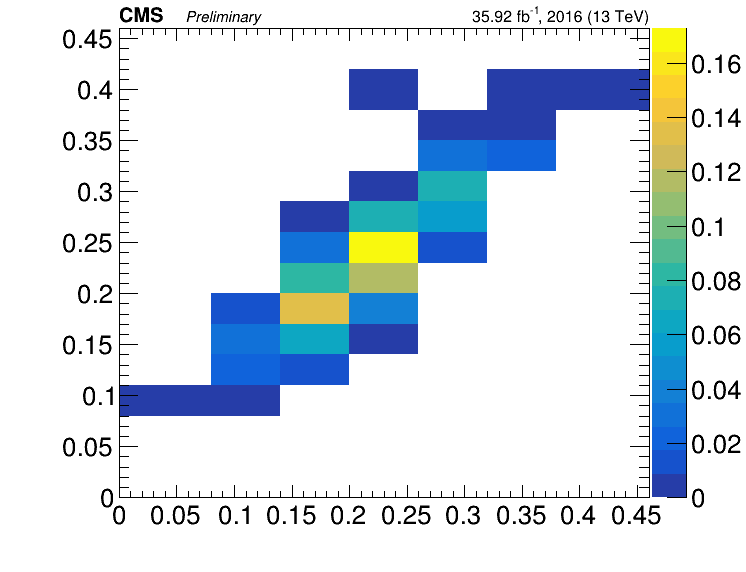

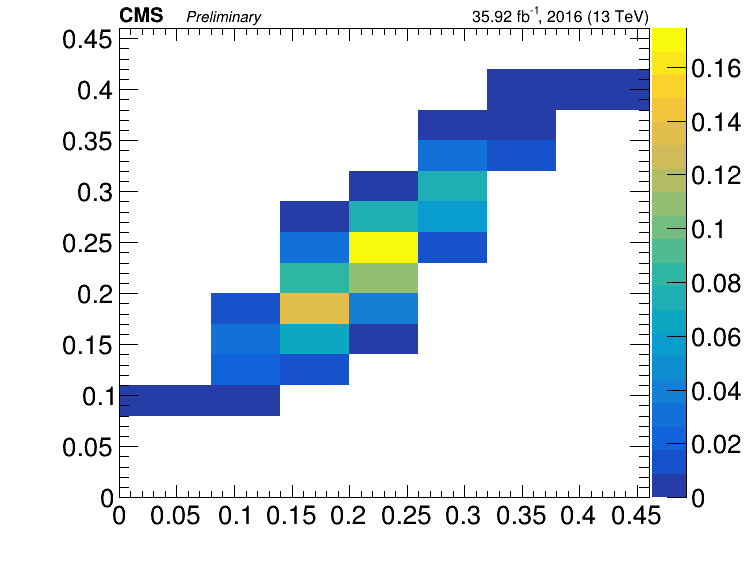

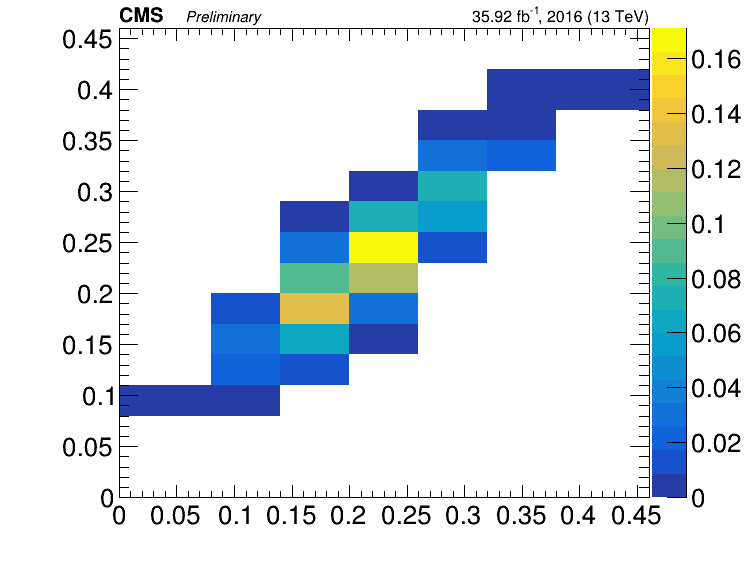

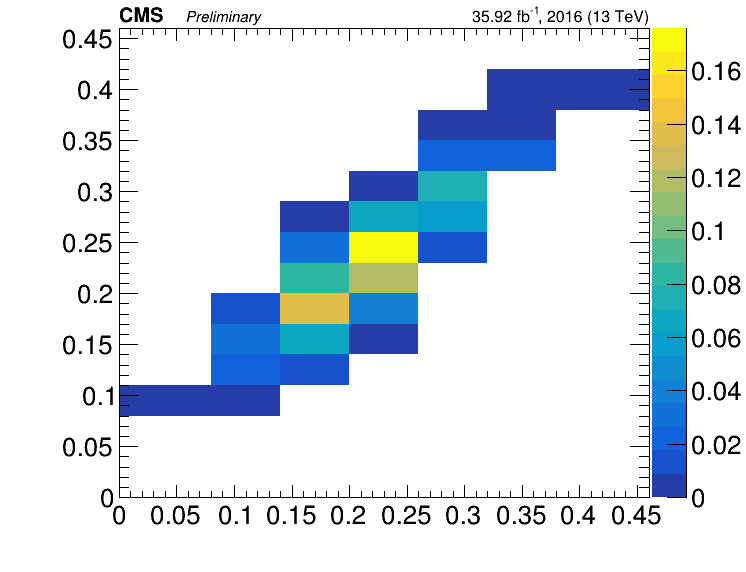

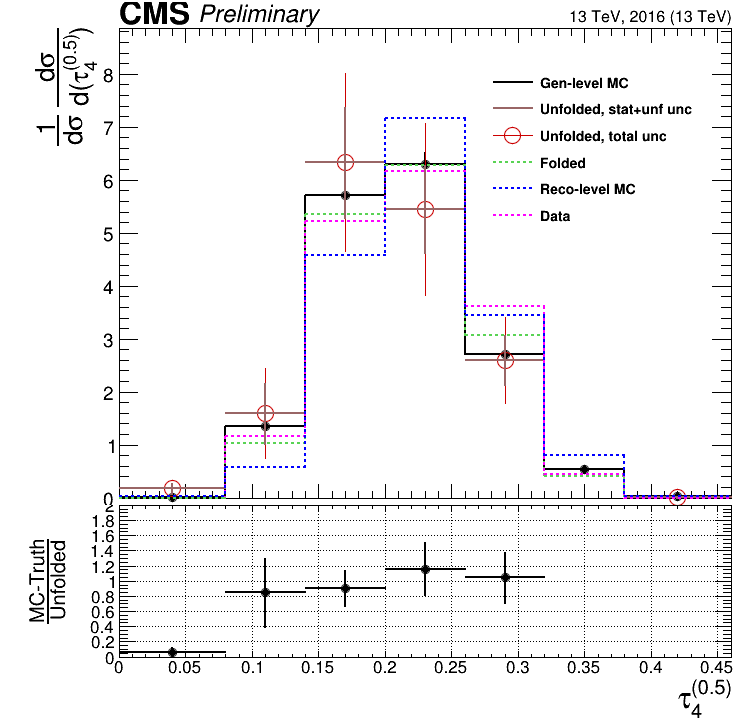

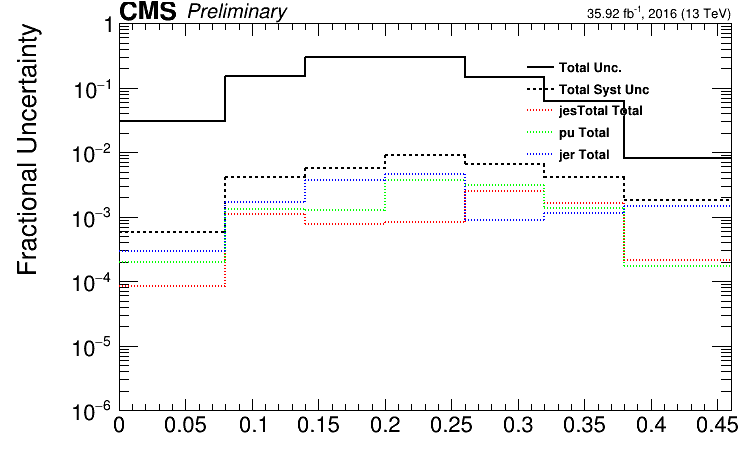

In [13]:
for ivar in variables:
    
    print '|------> Unfolding '+ivar

    ######## Cross check: plotting data vs all MC Scaled
    print '|------> Cross check: plotting data vs all MC'
    allBkgHisto = dataHistos['data_recoJet'+ivar+'_nom'+sel].Clone()
    allBkgHisto.Reset()
    allBkgHistoNorm = allBkgHisto.Clone()
    allBkgHistoGenBin = dataHistos['data_recoJet'+ivar+'_nom'+sel+'_genBin'].Clone()
    allBkgHistoGenBin.Reset()
    for ibkg in bkgHistos:
        if ibkg.endswith('_recoJet'+ivar+'_nom'+sel): allBkgHisto.Add( bkgHistos[ibkg].Clone() )
        if ibkg.endswith('_recoJet'+ivar+'_nom'+sel+'_genBin'): allBkgHistoGenBin.Add( bkgHistos[ibkg].Clone() )
        if ibkg.endswith('_recoJet'+ivar+'_nom'+sel+'_Normalized'): allBkgHistoNorm.Add( bkgHistos[ibkg].Clone() )
    allMCHisto = allBkgHisto.Clone()
    allMCHisto.Add( signalHistos[ next(iter(sigFiles))+'_recoJet'+ivar+'_nom'+sel ].Clone() )
    plotSimpleComparison( dataHistos['data_recoJet'+ivar+'_nom'+sel].Clone(), 'data', allMCHisto, 'allBkgs', ivar+'_from'+('Data' if process.startswith('data') else 'MC')+'_'+next(iter(sigFiles))+"_nom", rebinX=variables[ivar][0], version=sel+'_'+version  )
    allMCHistoNorm = allBkgHistoNorm.Clone()
    allMCHistoNorm.Add( signalHistos[ next(iter(sigFiles))+'_recoJet'+ivar+'_nom'+sel+"_Normalized" ].Clone() )
    plotSimpleComparison( dataHistos['data_recoJet'+ivar+'_nom'+sel+"_Normalized"].Clone(), 'data', allMCHistoNorm, 'allBkgs', ivar+'_from'+('Data' if process.startswith('data') else 'MC')+'_'+next(iter(sigFiles))+"_nom_Normalized", rebinX=variables[ivar][0], version=sel+'_'+version  )

    ######## Cross check: plotting response matrix
    #tdrStyle.SetPadRightMargin(0.12)
    print '|------> Cross check: plotting response matrix for signal'
    can2D = ROOT.TCanvas(ivar+'can2D', ivar+'can2D', 750,600 )
    signalHistos[next(iter(sigFiles))+'_respJet'+ivar+'_nom'+sel].SetStats(0)
    signalHistos[next(iter(sigFiles))+'_respJet'+ivar+'_nom'+sel].Draw("colz")
    can2D.SetRightMargin(0.13)
    CMS_lumi.extraText = "  Preliminary"
    CMS_lumi.lumi_13TeV = str( round( (lumi/1000.), 2 ) )+" fb^{-1}, 2016"
    #CMS_lumi.lumi_13TeV = "13 TeV, 2016"
    CMS_lumi.relPosX = 0.11
    CMS_lumi.CMS_lumi(can2D, 4, 0)
    can2D.Draw()
    can2D.SaveAs('Plots/'+ivar+'_from'+('Data' if process.startswith('data') else 'MC')+'_'+next(iter(sigFiles))+sel+'_responseMatrix'+version+'.png')
    can2DNorm = ROOT.TCanvas(ivar+'can2DNorm', ivar+'can2DNorm', 750, 600 )
    signalHistos[next(iter(sigFiles))+'_respJet'+ivar+'_nom'+sel+'_Normalized'].SetStats(0)
    signalHistos[next(iter(sigFiles))+'_respJet'+ivar+'_nom'+sel+'_Normalized'].Draw("colz")
    can2DNorm.SetRightMargin(0.13)
    CMS_lumi.extraText = "  Preliminary"
    CMS_lumi.lumi_13TeV = str( round( (lumi/1000.), 2 ) )+" fb^{-1}, 2016"
    #CMS_lumi.lumi_13TeV = "13 TeV, 2016"
    CMS_lumi.relPosX = 0.11
    CMS_lumi.CMS_lumi(can2DNorm, 4, 0)
    can2DNorm.Draw()
    can2DNorm.SaveAs('Plots/'+ivar+'_from'+('Data' if process.startswith('data') else 'MC')+'_'+next(iter(sigFiles))+sel+'Normalized_responseMatrix'+version+'.png')

    ####### Removing bkgs from data
    dataMinusBkgs = dataHistos[ 'data_recoJet'+ivar+'_nom'+sel ].Clone()
    dataMinusBkgs.Add( allBkgHisto.Clone(), -1 )
    dataMinusBkgs.Scale( 1/dataMinusBkgs.Integral() )
    dataMinusBkgsGenBin = dataHistos[ 'data_recoJet'+ivar+'_nom'+sel+'_genBin' ].Clone()
    dataMinusBkgsGenBin.Add( allBkgHistoGenBin.Clone(), -1 )
    dataMinusBkgsGenBin.Scale( 1/dataMinusBkgsGenBin.Integral() )

    ######## TUnfold part
    print '|------> TUnfolding starts:'

    ##### Defining options for TUnfold
    tunfolder = ROOT.TUnfoldDensity(
                                        signalHistos[next(iter(sigFiles))+'_respJet'+ivar+'_nom'+sel+'_Normalized'], ### response matrix
                                        #signalHistos[next(iter(sigFiles))+'_respJet'+ivar+'_nom'+sel], ### response matrix
                                        ROOT.TUnfold.kHistMapOutputHoriz,  #### kHistMapOutputVert if x->reco and y->gen, kHistMapOutputHoriz if x->gen and y->reco
                                        ROOT.TUnfold.kRegModeCurvature,   ##### Regularization Mode : ROOT.TUnfold.kRegModeCurvature regularizes based on the 2nd derivative of the output. More information wrt the other options can be gained from reading the source code
                                        ROOT.TUnfold.kEConstraintNone,    ##### Constraint : TUnfold.kEConstraintNone meaning we do not constrain further, the other option is to force constraint of area. (Need to look into this!!)
                                        ROOT.TUnfoldDensity.kDensityModeBinWidth  ##### Density Mode: ROOT.TUnfoldDensity.kDensityModeBinWidth uses the bin width to normalize the event rate in a given bin, accounting for non-uniformity in bin widths as discussed in section 7.2.1 of the TUnfold paper
                                        )

    ##### Defining input (data recoJet )
    print '|------> TUnfolding adding input:'
    #tunfolder.SetInput( dataHistos[ 'data_recoJet'+ivar+'_nom'+sel ].Clone() )
    tunfolder.SetInput( dataMinusBkgs )

    ###### Removing bkgs from data using TUnfold. Better to subtract bkgs beforehand
    #for ibkg in bkgHistos:
    #    if ibkg.endswith('_recoJet'+ivar+'_nom'+sel+'_Normalized'):
    #        print '|--------> Removing this bkg: ', ibkg
    #        tunfolder.SubtractBackground( bkgHistos[ibkg], ibkg )

    ###### Adding SYS unc
    if len(sysUncert)>0 :
        print '|------> TUnfolding adding uncert:'
        for sys in sysUncert:
            #plotSysComparison( signalHistos[next(iter(sigFiles))+'_recoJet'+ivar+'_nom'+sel+"_Normalized"],
            #                    signalHistos[next(iter(sigFiles))+'_recoJet'+ivar+sys+'Up'+sel+"_Normalized"],
            #                    signalHistos[next(iter(sigFiles))+'_recoJet'+ivar+sys+'Down'+sel+"_Normalized"],
            #                    ivar+'_'+next(iter(sigFiles)),
            #                    sys.split('_')[1],
            #                    version=sel+'_'+version
            #                    )
            for upDown in [ 'Up', 'Down' ]:
                print sys+upDown
                tunfolder.AddSysError(
                                    signalHistos[next(iter(sigFiles))+'_respJet'+ivar+sys+upDown+sel+"_Normalized"],
                                    sys+upDown,
                                    ROOT.TUnfold.kHistMapOutputHoriz,
                                    ROOT.TUnfoldSys.kSysErrModeMatrix, #### kSysErrModeMatrix the histogram sysError corresponds to an alternative response matrix. kSysErrModeShift the content of the histogram sysError are the absolute shifts of the response matrix. kSysErrModeRelative the content of the histogram sysError specifies the relative uncertainties
                                    )
                can2DNorm = ROOT.TCanvas(ivar+'can2DNorm'+sys+upDown, ivar+'can2DNorm'+sys+upDown, 750, 600 )
                signalHistos[next(iter(sigFiles))+'_respJet'+ivar+sys+upDown+sel+"_Normalized"].SetStats(0)
                signalHistos[next(iter(sigFiles))+'_respJet'+ivar+sys+upDown+sel+"_Normalized"].Draw("colz")
                can2DNorm.SetRightMargin(0.13)
                CMS_lumi.extraText = "  Preliminary"
                CMS_lumi.lumi_13TeV = str( round( (lumi/1000.), 2 ) )+" fb^{-1}, 2016"
                #CMS_lumi.lumi_13TeV = "13 TeV, 2016"
                CMS_lumi.relPosX = 0.11
                CMS_lumi.CMS_lumi(can2DNorm, 4, 0)
                can2DNorm.Draw()
                can2DNorm.SaveAs('Plots/'+ivar+'_from'+('Data' if process.startswith('data') else 'MC')+'_'+next(iter(sigFiles))+sel+sys+upDown+'Normalized_responseMatrix'+version+'.png')

    ###### Running the unfolding
    print '|------> TUnfolding doUnfold:'
    tunfolder.DoUnfold(0)

    ###### Regularization
#        nScan=50
#        tauMin=0.0
#        tauMax=0.0
#        iBest=0
#
#        logTauX = ROOT.MakeNullPointer(ROOT.TSpline)
#        logTauY = ROOT.MakeNullPointer(ROOT.TSpline)
#        lCurve = ROOT.MakeNullPointer(ROOT.ROOT.TGraph)
#        ## this method scans the parameter tau and finds the kink in the L curve finally, the unfolding is done for the best choice of tau
#        tunfolder.ScanLcurve(nScan,tauMin,tauMax,lCurve,logTauX,logTauY)
    #########################
    ROOT.gStyle.SetOptStat(0)

    ##### Get output of unfolding
    unfoldHisto = tunfolder.GetOutput("unfoldHisto")

    #### Get various covariances
    print '|------> TUnfolding covariances'
    cov = tunfolder.GetEmatrixTotal("cov", "Covariance Matrix")
    cov_uncorr = tunfolder.GetEmatrixSysUncorr("cov_uncorr", "Covariance Matrix from Uncorrelated Uncertainties")
    cov_uncorr_data = tunfolder.GetEmatrixInput("cov_uncorr_data", "Covariance Matrix from Stat Uncertainties of Input Data")
    unfoldHistowoUnc = unfoldHisto.Clone()        # Unfolding and stat unc
    unfoldHistoStatUnc = unfoldHisto.Clone("unfoldHistoStatUnc")        # Unfolding and stat unc
    unfoldHistoTotUnc = unfoldHisto.Clone("unfoldHistoTotUnc")          # Total uncertainty
    for ibin in range( 0, unfoldHisto.GetNbinsX()+1 ):
        unc_tot = ROOT.TMath.Sqrt( cov.GetBinContent(ibin,ibin) )
        unfoldHistoTotUnc.SetBinContent(ibin, unc_tot )
        unfoldHisto.SetBinError(ibin, unc_tot )


    ##### Get systematic shifts of output
    uncerUnfoldHisto = {}
    if len(sysUncert)>0 :
        print '|------> TUnfolding uncertainties:'
        unfoldHistoSysUnc = unfoldHisto.Clone("unfoldHistoSysUnc")          # Syst uncertainty
        unfoldHistoSysUnc.Reset()
        unfoldHistoSysUnc.SetLineStyle(2)

        for sys in sysUncert:
            for upDown in [ 'Up', 'Down' ]:
                print sys+upDown
                uncerUnfoldHisto[ivar+sys+upDown] = tunfolder.GetDeltaSysSource(sys+upDown, "unfoldHisto_"+sys+upDown+"shift", "-1#sigma")
                try: uncerUnfoldHisto[ivar+sys+upDown].SetLineStyle(2)
                except ReferenceError: uncerUnfoldHisto.pop( ivar+sys+upDown, None )

            # Create total uncertainty and sys uncertainty plots.
            uncerUnfoldHisto[ivar+sys+'Total'] = unfoldHisto.Clone("unfoldHistoSysUnc")          # Syst uncertainty
            uncerUnfoldHisto[ivar+sys+'Total'].Reset()
            uncerUnfoldHisto[ivar+sys+'Total'].SetLineStyle(3)
            for i in xrange( 0, unfoldHisto.GetNbinsX() + 1):
                try: yup = abs( uncerUnfoldHisto[ivar+sys+'Up'].GetBinContent(i))
                except KeyError: yup = 0
                try: ydn = abs( uncerUnfoldHisto[ivar+sys+'Down'].GetBinContent(i))
                except KeyError: ydn = 0
                dy = ROOT.TMath.Sqrt( (yup**2 + ydn**2) )
                uncerUnfoldHisto[ivar+sys+'Total'].SetBinContent(i, dy )
            unfoldHistoSysUnc.Add( uncerUnfoldHisto[ivar+sys+'Total'] )

    ###### Plot unfolding results
    #tdrStyle.SetPadRightMargin(0.05)
    #tdrStyle.SetPadLeftMargin(0.15)
    can = ROOT.TCanvas('can', 'can',  10, 10, 750, 750 )
    pad1 = ROOT.TPad("pad1", "Main",0,0.207,1.00,1.00,-1)
    pad2 = ROOT.TPad("pad2", "Ratio",0,0.00,1.00,0.30,-1);
    pad1.Draw()
    pad2.Draw()
    #ROOT.gStyle.SetOptStat(0)

    pad1.cd()
    
    #tmpPad1 = pad1.DrawFrame( 0, 0.3, 1, 1.7 )
    
    #tmpPad1.GetYaxis().SetTitle( '#frac{1}{d#sigma} #frac{d#sigma}{d(#tau_{4}^{(0.5)})}' )
    #tmpPad1.GetYaxis().SetTitleOffset(0.9)
    #tmpPad1.GetYaxis().SetTitleSize(28)
    #tmpPad1.GetYaxis().SetLabelSize(20)
    #tmpPad1.SetStats(0)
    
    leg=ROOT.TLegend(0.65,0.6,0.95,0.88)
    leg.SetLineColor(0)
    leg.SetLineWidth(0)
    leg.SetBorderSize(0)
    leg.SetFillStyle(0)
    #leg.SetTextSize(0.8)

    #genJetHisto = signalHistos[ next(iter(sigFiles))+'_genJet'+ivar+sel ].Clone()
    genJetHisto = signalHistos[ next(iter(sigFiles))+'_genJet'+ivar+sel+'_Normalized' ].Clone()
    genJetHisto.GetYaxis().SetTitle( '#frac{1}{d#sigma} #frac{d#sigma}{d(#tau_{4}^{(0.5)})}' )
    genJetHisto.GetYaxis().SetTitleSize( 0.05 )
    genJetHisto.GetYaxis().SetTitleOffset( 0.9 )
    #genJetHisto.GetYaxis().CenterTitle()
    genJetHisto.SetStats(0)
    genJetHisto.Scale(1, 'width')  ### divide by bin width
    genJetHisto.SetLineWidth(2)
    genJetHisto.GetYaxis().SetLabelSize(0.037)
    genJetHisto.SetLineColor(1)
    pad1.Modified()
    pad1.Update()

    leg.AddEntry( genJetHisto, 'Gen-level MC', 'l' )

    #unfoldHisto = tunfolder.GetOutput("unfolded")
    #if len(variables[ivar])>1: unfoldHisto = unfoldHisto.Rebin( len(variables[ivar])-1, unfoldHisto.GetName()+"_rebin", array( 'd', variables[ivar] ) )
    #else: unfoldHisto.Rebin( variables[ivar][0] )
    

    unfoldHistowoUnc.Scale(1, 'width')  ### divide by bin width
    unfoldHistowoUnc.SetMarkerStyle(0)
    unfoldHistowoUnc.SetMarkerColor(ROOT.kRed-5)
    unfoldHistowoUnc.SetLineColor(ROOT.kRed-5)
    unfoldHistowoUnc.SetLineWidth(2)
    unfoldHistowoUnc.SetStats(0)
    leg.AddEntry( unfoldHistowoUnc, 'Unfolded, stat+unf unc', 'l' )
    
    unfoldHisto.Scale(1, 'width')  ### divide by bin width
    unfoldHisto.SetMarkerStyle(4)
    unfoldHisto.SetMarkerSize(2)
    unfoldHisto.SetMarkerColor(ROOT.kRed+1)
    unfoldHisto.SetLineColor(ROOT.kRed+1)
    unfoldHisto.SetStats(0)
    leg.AddEntry( unfoldHisto, 'Unfolded, total unc', 'pl' )

    foldHisto = tunfolder.GetFoldedOutput("folded") #, 'folded', 'folded', , False)
    if len(variables[ivar])>1: foldHisto = foldHisto.Rebin( len(variables[ivar])-1, foldHisto.GetName()+"_rebin", array( 'd', variables[ivar] ) )
    else: foldHisto.Rebin( 2 )
    foldHisto.Scale(1, 'width')  ### divide by bin width
    foldHisto.SetLineWidth(2)
    foldHisto.SetLineStyle(2)
    foldHisto.SetLineColor(8)
    foldHisto.SetStats(0)
    leg.AddEntry( foldHisto, 'Folded', 'l' )

    if process.startswith('data'):
        #recoJetHisto = signalHistos[ next(iter(sigFiles))+'_recoJet'+ivar+'_nom'+sel+'_Normalized' ].Clone()
        recoJetHisto = signalHistos[ next(iter(sigFiles))+'_recoJet'+ivar+'_nom'+sel+'_genBin' ].Clone()
        recoJetHisto.Scale(1/recoJetHisto.Integral(), 'width')  ### divide by bin width
        recoJetHisto.SetLineWidth(2)
        recoJetHisto.SetLineStyle(2)
        recoJetHisto.SetLineColor(ROOT.kBlue)
        leg.AddEntry( recoJetHisto, 'Reco-level MC', 'l' )

    dataJetHisto = dataMinusBkgsGenBin.Clone()
    dataJetHisto.Scale(1/dataJetHisto.Integral(), 'width')  ### divide by bin width
    dataJetHisto.SetLineWidth(2)
    dataJetHisto.SetLineStyle(2)
    dataJetHisto.SetLineColor(ROOT.kMagenta)
    dataJetHisto.SetStats(0)
    leg.AddEntry( dataJetHisto, ('Data' if process.startswith('data') else 'MC Closure' ), 'l' )

    
    
    genJetHisto.SetMaximum( 1.4*max([ genJetHisto.GetMaximum(), unfoldHisto.GetMaximum(), unfoldHistowoUnc.GetMaximum(), dataJetHisto.GetMaximum() ] )  )
    pad1.Update()
    pad1.Modified()
    
    genJetHisto.Draw( "histe")
    unfoldHisto.Draw( "same")
    unfoldHistowoUnc.Draw( "e1 same")
    foldHisto.Draw( "hist same")
    dataJetHisto.Draw( "hist same")
    if process.startswith('data'): recoJetHisto.Draw( "hist same")
    #ROOT.gStyle.SetOptStat(0)
    leg.Draw()
    CMS_lumi.extraText = "Preliminary"
    CMS_lumi.cmsTextSize = 1.2
    #CMS_lumi.lumi_13TeV = str( round( (lumi/1000.), 2 ) )+" fb^{-1}, 13 TeV, 2016"
    CMS_lumi.lumi_13TeV = "13 TeV, 2016"
    CMS_lumi.cmsTextSize = 1.2
    CMS_lumi.relPosX = 0.13
    CMS_lumi.CMS_lumi(pad1, 4, 0)

    pad2.cd()
    ROOT.gStyle.SetOptFit(1)
    ROOT.gStyle.SetOptStat(0000000)
    pad2.SetGrid()
    pad2.SetTopMargin(0)
    pad2.SetBottomMargin(0.3)
    #tmpPad2= pad2.DrawFrame( 0, 0.5, 1, 1. )
    
    hRatioUp = genJetHisto.Clone()
    hRatioUp.GetYaxis().SetTitle( "#frac{MC-Truth}{Unfolded}" )
    hRatioUp.GetYaxis().SetTitleOffset( 0.6)
    hRatioUp.GetYaxis().SetTitleSize(0.1)
    hRatioUp.GetYaxis().SetLabelSize(0.085)
    hRatioUp.GetXaxis().SetTitle("#tau_{4}^{(0.5)}")
    hRatioUp.GetXaxis().SetTitleOffset( 0.8)
    hRatioUp.GetXaxis().SetTitleSize( 0.15)
    hRatioUp.GetXaxis().SetLabelSize(0.085)
    hRatioUp.GetYaxis().CenterTitle()
    hRatioUp.Divide( unfoldHisto )
    hRatioUp.GetYaxis().SetRangeUser(0.,2.)
    hRatioUp.Draw('P0')
    
    #tmpPad2.SetLabelSize(16, 'x')
    #tmpPad2.SetTitleSize(19, 'x')
    #tmpPad2.SetLabelSize(16., 'y')
    #tmpPad2.SetTitleSize(19., 'y')
    #tmpPad2.SetNdivisions(505, 'x')
    #tmpPad2.SetNdivisions(505, 'y')
    #tmpPad2.SetMarkerStyle(8)
    #hRatioUp.SetTitle("#tau_{4}^{(0.5)}")
    #hRatioUp.SetLabelSize(18)
    
    #hRatioUp.GetXaxis().SetTitle( genJetHisto.GetXaxis().GetTitle() )
    pad2.Modified()

    #pad2.Update()
    #pad2.Modified()
    #hRatioDown.Draw('P same')
    #pad1.cd()
    #leg.Draw()
    #can.Update()
    #can.Modified()
    can.Draw()
    can.SaveAs('Plots/'+ivar+sel+'_from'+('Data' if process.startswith('data') else 'MC')+(''.join(sysUncert))+'_Tunfold_'+version+'.png')

    canUnc = ROOT.TCanvas('canUnc', 'canUnc',  10, 10, 750, 500 )
    canUnc.SetTitle("")
    #canUnc.SetLogy()
    #ROOT.gStyle.SetOptStat(0)
    legend=ROOT.TLegend(0.70,0.65,0.90,0.88)
    legend.SetFillStyle(0)
    legend.SetTextSize(0.03)
    legend.SetBorderSize(0)
    legend.SetLineStyle(0)
    legend.AddEntry( unfoldHistoTotUnc, 'Total Unc.', 'l' )

    unfoldHistoTotUnc.SetStats(0)
    unfoldHistoTotUnc.SetLineWidth(2)
    unfoldHistoTotUnc.Scale( 1/(unfoldHistoTotUnc.Integral()) )
    unfoldHistoTotUnc.SetMaximum(1.)
    unfoldHistoTotUnc.SetMinimum(0.000001)
    unfoldHistoTotUnc.GetYaxis().SetTitle('Fractional Uncertainty')
    unfoldHistoTotUnc.Draw('hist')

    if len(sysUncert)>0 :
        legend.AddEntry( unfoldHistoSysUnc, 'Total Syst Unc', 'l' )
        unfoldHistoSysUnc.Scale( 1/unfoldHistoTotUnc.Integral() )
        unfoldHistoSysUnc.SetLineWidth(2)
        unfoldHistoSysUnc.SetStats(0)
        unfoldHistoSysUnc.Draw("hist same")
        dummy=2
        for k in uncerUnfoldHisto:
            if k.endswith('Total'):
                for i in sysUncert:
                    if i in k:
                        legend.AddEntry( uncerUnfoldHisto[k], i.split('_')[1]+" Total", 'l' )
                uncerUnfoldHisto[k].SetLineColor(dummy)
                uncerUnfoldHisto[k].SetLineWidth(2)
                uncerUnfoldHisto[k].SetStats(0)
                uncerUnfoldHisto[k].Scale( 1/unfoldHistoTotUnc.Integral() )
                uncerUnfoldHisto[k].Draw("hist same")
                dummy=dummy+1

    legend.Draw()
    CMS_lumi.extraText = "Preliminary"
    CMS_lumi.lumi_13TeV = str( round( (lumi/1000.), 2 ) )+" fb^{-1}, 2016"
    #CMS_lumi.lumi_13TeV = "2016"
    ROOT.gPad.SetLogy()
    CMS_lumi.relPosX = 0.11
    CMS_lumi.CMS_lumi(canUnc, 4, 0)
    canUnc.Draw()
    canUnc.SaveAs('Plots/'+ivar+sel+'_from'+('Data' if process.startswith('data') else 'MC')+(''.join(sysUncert))+'_Tunfold_UNC_'+version+'.png')


In [14]:
variables = {}
#variables[ '_tau_0p5_1' ] = [10] #gen_bins2  ### (reco,gen)
#variables[ '_tau_1_0' ] = array('d',[0., 0.1, 0.16, 0.22, 0.28, 0.34, 0.4, 0.46, 0.52, 0.58, 0.64, 0.8])#[0. 0.25 0.30625 0.3625 0.418750.475 0.53125 0.5875 0.64375 0.7 0.8 ][0., 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.65]#[ 6]
#variables[ '_tau_2_0' ] = [ 3]
#variables[ '_tau_0p5_1' ] = [10] #gen_bins2  ### (reco,gen)
#variables[ '_tau_1_1' ] = array('d',[0., 0.04, 0.08, 0.12, 0.16, 0.22, 0.26, 0.3, 0.5])#[ 8]
#variables[ '_tau_2_1' ] = [ 5]
#variables[ '_tau_0p5_2' ] = [8] #gen_bins2  ### (reco,gen)
#variables[ '_tau_1_2' ] = array('d',[0., 0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.35])#[ 4]
#variables[ '_tau_2_2' ] = [ 4]

#variables[ '_tau_0p5_3' ] = [8] #gen_bins2  ### (reco,gen)
variables[ '_tau_1_3' ] = array('d', [0., 0.03, 0.07, 0.11, 0.15, 0.21])#[ 5]
#variables[ '_tau_2_3' ] = [0., 0.006, 0.012, 0.018, 0.024, 0.03, 0.04, 0.055, 0.075, 0.11] #[4]#[0., 0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.0225, 0.025]

sysUncert = [ '_jesTotal', '_jer', '_pu' ]
print variables

{'_tau_1_3': array('d', [0.0, 0.03, 0.07, 0.11, 0.15, 0.21])}


In [15]:
sel= '_topSel'
process = 'data'
version = 'v01_fin'

In [16]:
dataFile = {}
dataFile['data'] = [ TFile('Histos_SysUnc/jetObservables_histograms_SingleMuonRun2016ALL.root' ), 'Data', 'kBlack' ]

In [17]:
sigFiles = {}
sigFiles['TT'] = [ TFile('Histos_SysUnc/jetObservables_histograms_TT_TuneCUETP8M2T4_13TeV-powheg-pythia8.root'), 'ttbar (powheg)', 'kRed' ]
#sigFiles['TTJets'] = [ TFile('Histos_SysUnc/jetObservables_histograms_TTJets_TuneCUETP8M1_13TeV-madgraphMLM-pythia8.root'), 'ttbar (MG)', 'kBlue' ]

In [18]:
bkgFiles = {}
bkgFiles['ST_s-channel_4f_InclusiveDecays'] = [ TFile('Histos_SysUnc/jetObservables_histograms_ST_s-channel_4f_InclusiveDecays_13TeV-amcatnlo-pythia8.root' ), 'Single top', 'kMagenta' ]
bkgFiles['ST_t-channel_antitop'] = [ TFile('Histos_SysUnc/jetObservables_histograms_ST_t-channel_antitop_4f_inclusiveDecays_13TeV-powhegV2-madspin-pythia8_TuneCUETP8M1.root' ), 'Single top', 'kMagenta' ]
bkgFiles['ST_t-channel_top'] = [ TFile('Histos_SysUnc/jetObservables_histograms_ST_t-channel_top_4f_inclusiveDecays_13TeV-powhegV2-madspin-pythia8_TuneCUETP8M1.root' ), 'Single top', 'kMagenta' ]
bkgFiles['ST_tW_antitop'] = [ TFile('Histos_SysUnc/jetObservables_histograms_ST_tW_antitop_5f_inclusiveDecays_13TeV-powheg-pythia8_TuneCUETP8M2T4.root' ), 'Single top', 'kMagenta' ]
bkgFiles['ST_tW_top'] = [ TFile('Histos_SysUnc/jetObservables_histograms_ST_tW_top_5f_inclusiveDecays_13TeV-powheg-pythia8_TuneCUETP8M2T4.root' ), 'Single top', 'kMagenta' ]
#bkgFiles['WJets'] = [ TFile( inputFolder+'/jetObservables_histograms_WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8.root' ), 'WJets', 'kCyan' ]
###bkgFiles[] = [ '', TFile( inputFolder+'/jetObservables_histograms_'+ibkg+'.root' ), '', 'kMagenta' ]

In [19]:
dataHistos = loadHistograms( dataFile, variables, sel='_topSel', isMC=False )
signalHistos = loadHistograms( sigFiles, variables, sel='_topSel', sysUnc=sysUncert )
bkgHistos = loadHistograms( bkgFiles, variables, sel='_topSel', sysUnc=sysUncert ) 

New variable bins: array('d', [0.0, 0.015, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.18, 0.21]) recoJet_tau_1_3_nom_topSel array('d', [0.0, 0.03, 0.07, 0.11, 0.15, 0.21])
New variable bins: array('d', [0.0, 0.015, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.18, 0.21]) recoJet_tau_1_3_nom_topSel array('d', [0.0, 0.03, 0.07, 0.11, 0.15, 0.21])
New variable bins: array('d', [0.0, 0.015, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.18, 0.21]) recoJet_tau_1_3_jesTotalDown_topSel array('d', [0.0, 0.03, 0.07, 0.11, 0.15, 0.21])
New variable bins: array('d', [0.0, 0.015, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.18, 0.21]) recoJet_tau_1_3_jerDown_topSel array('d', [0.0, 0.03, 0.07, 0.11, 0.15, 0.21])
New variable bins: array('d', [0.0, 0.015, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.18, 0.21]) recoJet_tau_1_3_puDown_topSel array('d', [0.0, 0.03, 0.07, 0.11, 0.15, 0.21])
New variable bins: array('d', [0.0, 0.015, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.18, 0.21]) recoJet_tau_1_3_jesTo

New variable bins: array('d', [0.0, 0.015, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.18, 0.21]) recoJet_tau_1_3_jesTotalUp_topSel array('d', [0.0, 0.03, 0.07, 0.11, 0.15, 0.21])
New variable bins: array('d', [0.0, 0.015, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.18, 0.21]) recoJet_tau_1_3_jerUp_topSel array('d', [0.0, 0.03, 0.07, 0.11, 0.15, 0.21])
New variable bins: array('d', [0.0, 0.015, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.18, 0.21]) recoJet_tau_1_3_puUp_topSel array('d', [0.0, 0.03, 0.07, 0.11, 0.15, 0.21])
New variable bins TH2F: [0.0, 0.015, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.18, 0.21]
New variable bins TH2F: [0.0, 0.015, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.18, 0.21]
New variable bins TH2F: [0.0, 0.015, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.18, 0.21]
New variable bins TH2F: [0.0, 0.015, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.18, 0.21]
New variable bins TH2F: [0.0, 0.015, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.18, 0.21]
New variable bin

Warning in <TH1F::Rebin>: Bin edge 2 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1F::Rebin>: Bin edge 2 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1F::Rebin>: Bin edge 2 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1F::Rebin>: Bin edge 2 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1F::Rebin>: Bin edge 2 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1F::Rebin>: Bin edge 2 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1F::Rebin>: Bin edge 2 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1F::Rebin>: Bin edge 2 of rebinned

|------> Unfolding _tau_1_3
|------> Cross check: plotting data vs all MC
('Processing.......', '_tau_1_3_fromData_TT_nom_dataallBkgs_simpleComparisonPlot_topSel_v01_fin.png')
('Processing.......', '_tau_1_3_fromData_TT_nom_Normalized_dataallBkgs_simpleComparisonPlot_topSel_v01_fin.png')
|------> Cross check: plotting response matrix for signal
35.92 fb^{-1}, 2016 (13 TeV)
35.92 fb^{-1}, 2016 (13 TeV)
|------> TUnfolding starts:
|------> TUnfolding adding input:
|------> TUnfolding adding uncert:
_jesTotalUp
35.92 fb^{-1}, 2016 (13 TeV)
_jesTotalDown
35.92 fb^{-1}, 2016 (13 TeV)
_jerUp
35.92 fb^{-1}, 2016 (13 TeV)
_jerDown
35.92 fb^{-1}, 2016 (13 TeV)
_puUp
35.92 fb^{-1}, 2016 (13 TeV)
_puDown
35.92 fb^{-1}, 2016 (13 TeV)
|------> TUnfolding doUnfold:
|------> TUnfolding covariances
|------> TUnfolding uncertainties:
_jesTotalUp
_jesTotalDown
_jerUp
_jerDown
_puUp
_puDown
13 TeV, 2016 (13 TeV)
35.92 fb^{-1}, 2016 (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file Plots/_tau_1_3_fromData_TT_nom_dataallBkgs_simpleComparisonPlot_topSel_v01_fin.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file Plots/_tau_1_3_fromData_TT_nom_Normalized_dataallBkgs_simpleComparisonPlot_topSel_v01_fin.png has been created
Info in <TCanvas::Print>: png file Plots/_tau_1_3_fromData_TT_topSel_responseMatrixv01_fin.png has been created
Info in <TCanvas::Print>: png file Plots/_tau_1_3_fromData_TT_topSelNormalized_responseMatrixv01_fin.png has been created
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 10 input bins and 5 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #6 (xaxis:[ofl])
Info i

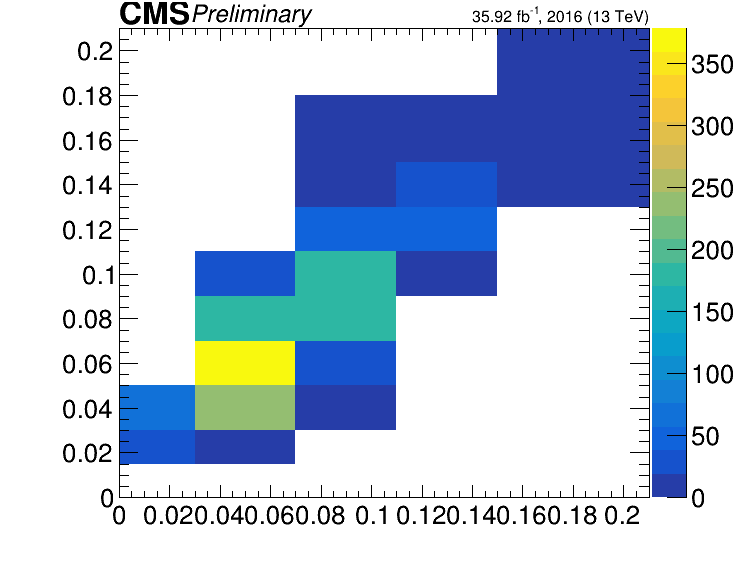

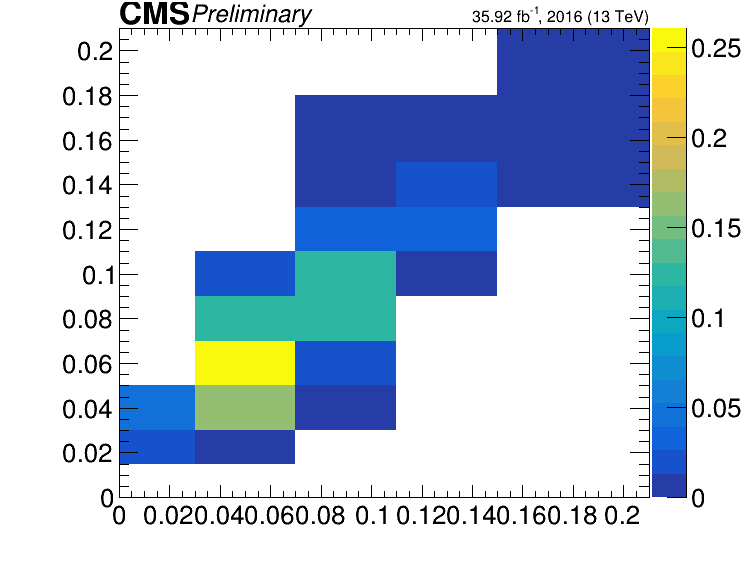

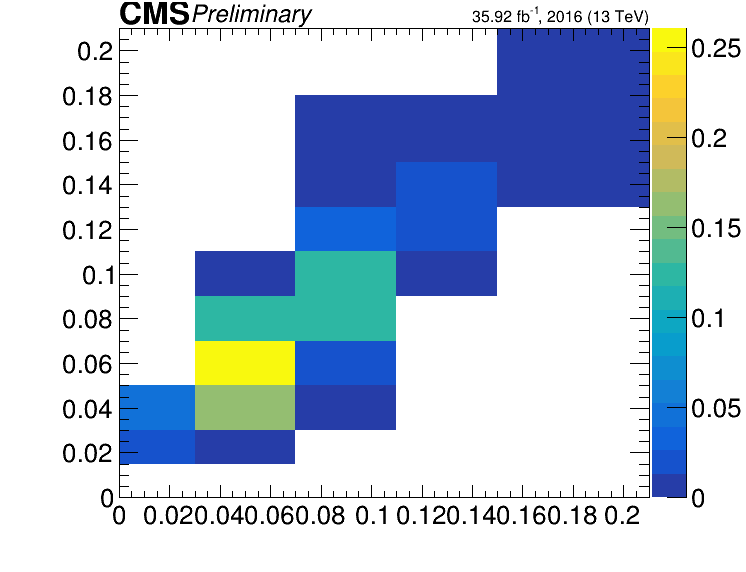

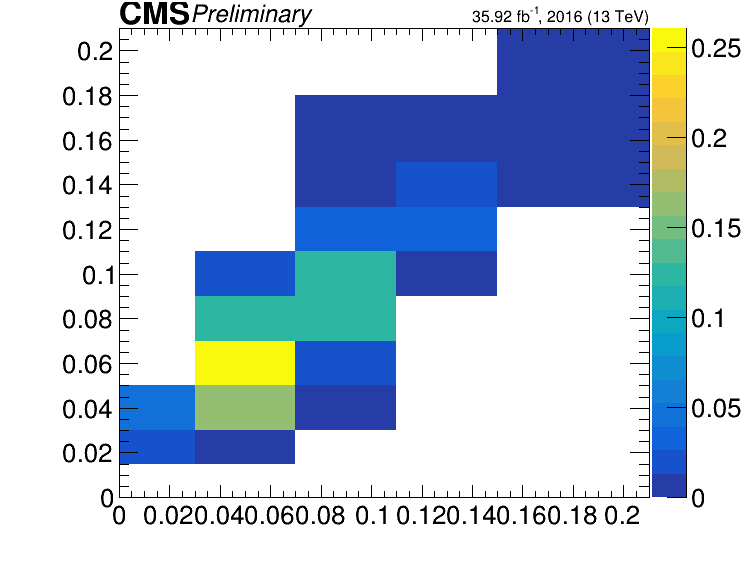

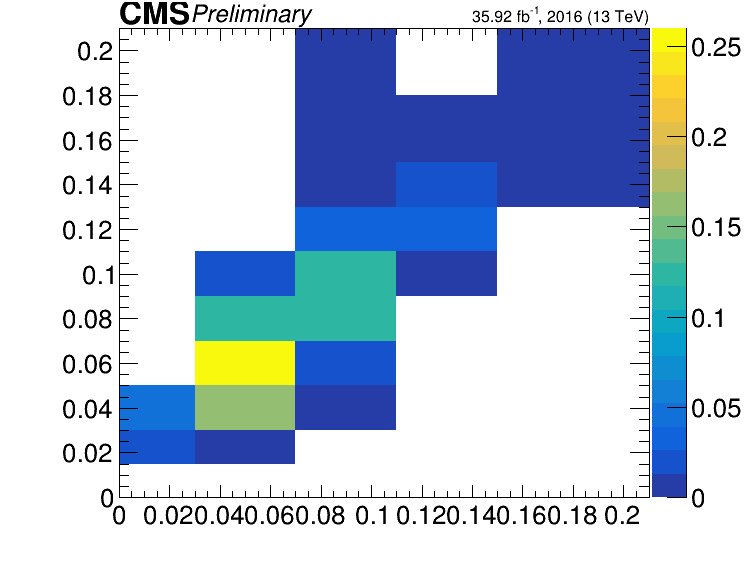

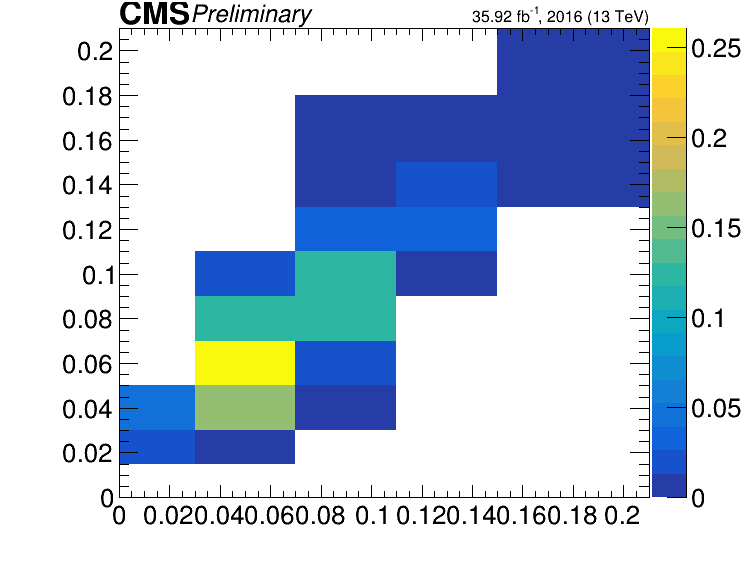

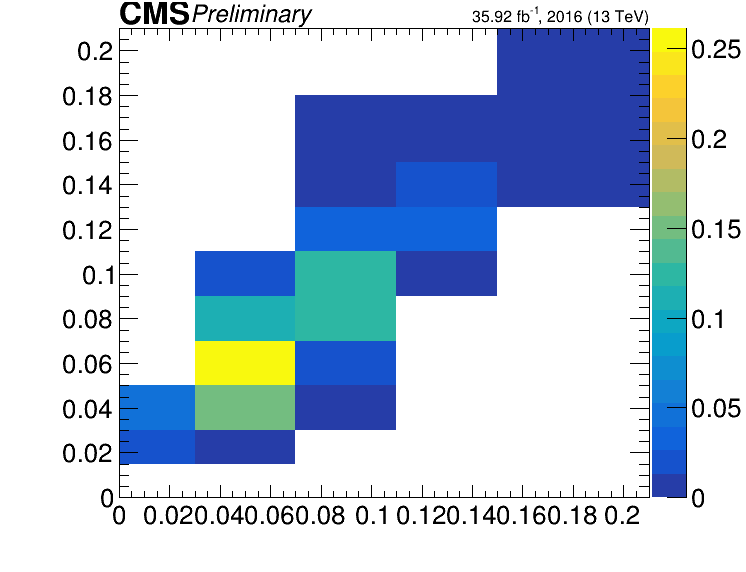

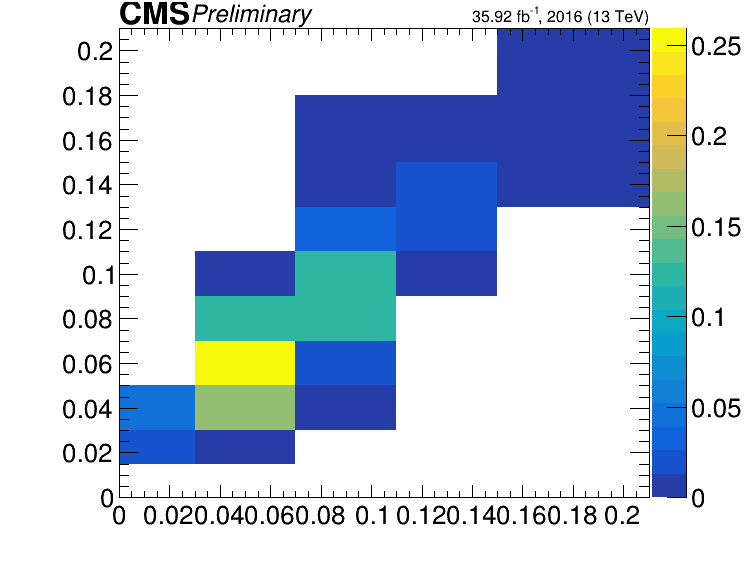

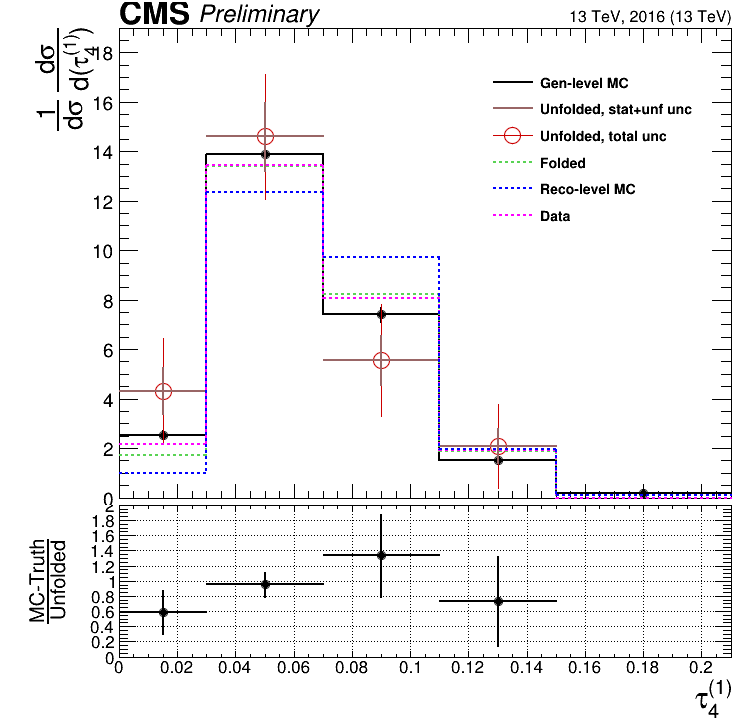

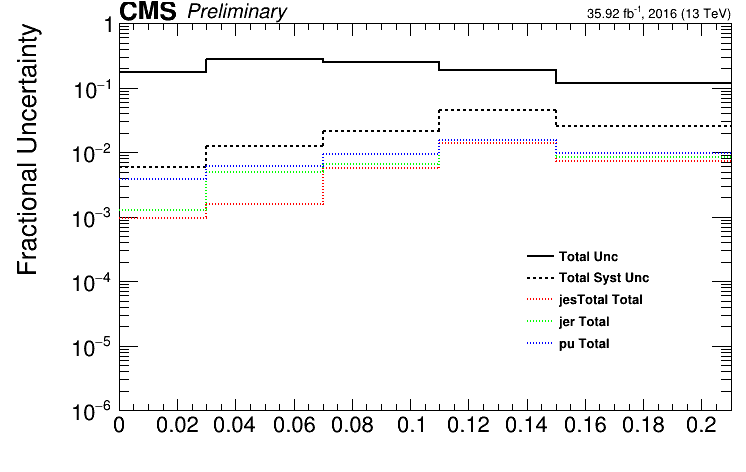

In [20]:
for ivar in variables:
    
    print '|------> Unfolding '+ivar

    ######## Cross check: plotting data vs all MC Scaled
    print '|------> Cross check: plotting data vs all MC'
    allBkgHisto = dataHistos['data_recoJet'+ivar+'_nom'+sel].Clone()
    allBkgHisto.Reset()
    allBkgHistoNorm = allBkgHisto.Clone()
    allBkgHistoGenBin = dataHistos['data_recoJet'+ivar+'_nom'+sel+'_genBin'].Clone()
    allBkgHistoGenBin.Reset()
    for ibkg in bkgHistos:
        if ibkg.endswith('_recoJet'+ivar+'_nom'+sel): allBkgHisto.Add( bkgHistos[ibkg].Clone() )
        if ibkg.endswith('_recoJet'+ivar+'_nom'+sel+'_genBin'): allBkgHistoGenBin.Add( bkgHistos[ibkg].Clone() )
        if ibkg.endswith('_recoJet'+ivar+'_nom'+sel+'_Normalized'): allBkgHistoNorm.Add( bkgHistos[ibkg].Clone() )
    allMCHisto = allBkgHisto.Clone()
    allMCHisto.Add( signalHistos[ next(iter(sigFiles))+'_recoJet'+ivar+'_nom'+sel ].Clone() )
    plotSimpleComparison( dataHistos['data_recoJet'+ivar+'_nom'+sel].Clone(), 'data', allMCHisto, 'allBkgs', ivar+'_from'+('Data' if process.startswith('data') else 'MC')+'_'+next(iter(sigFiles))+"_nom", rebinX=variables[ivar][0], version=sel+'_'+version  )
    allMCHistoNorm = allBkgHistoNorm.Clone()
    allMCHistoNorm.Add( signalHistos[ next(iter(sigFiles))+'_recoJet'+ivar+'_nom'+sel+"_Normalized" ].Clone() )
    plotSimpleComparison( dataHistos['data_recoJet'+ivar+'_nom'+sel+"_Normalized"].Clone(), 'data', allMCHistoNorm, 'allBkgs', ivar+'_from'+('Data' if process.startswith('data') else 'MC')+'_'+next(iter(sigFiles))+"_nom_Normalized", rebinX=variables[ivar][0], version=sel+'_'+version  )

    ######## Cross check: plotting response matrix
    #tdrStyle.SetPadRightMargin(0.12)
    print '|------> Cross check: plotting response matrix for signal'
    can2D = ROOT.TCanvas(ivar+'can2D', ivar+'can2D', 750,600 )
    signalHistos[next(iter(sigFiles))+'_respJet'+ivar+'_nom'+sel].SetStats(0)
    signalHistos[next(iter(sigFiles))+'_respJet'+ivar+'_nom'+sel].Draw("colz")
    can2D.SetRightMargin(0.13)
    CMS_lumi.extraText = "  Preliminary"
    CMS_lumi.lumi_13TeV = str( round( (lumi/1000.), 2 ) )+" fb^{-1}, 2016"
    #CMS_lumi.lumi_13TeV = "13 TeV, 2016"
    CMS_lumi.relPosX = 0.11
    CMS_lumi.CMS_lumi(can2D, 4, 0)
    can2D.Draw()
    can2D.SaveAs('Plots/'+ivar+'_from'+('Data' if process.startswith('data') else 'MC')+'_'+next(iter(sigFiles))+sel+'_responseMatrix'+version+'.png')
    can2DNorm = ROOT.TCanvas(ivar+'can2DNorm', ivar+'can2DNorm', 750, 600 )
    signalHistos[next(iter(sigFiles))+'_respJet'+ivar+'_nom'+sel+'_Normalized'].SetStats(0)
    signalHistos[next(iter(sigFiles))+'_respJet'+ivar+'_nom'+sel+'_Normalized'].Draw("colz")
    can2DNorm.SetRightMargin(0.13)
    CMS_lumi.extraText = "  Preliminary"
    CMS_lumi.lumi_13TeV = str( round( (lumi/1000.), 2 ) )+" fb^{-1}, 2016"
    #CMS_lumi.lumi_13TeV = "13 TeV, 2016"
    CMS_lumi.relPosX = 0.11
    CMS_lumi.CMS_lumi(can2DNorm, 4, 0)
    can2DNorm.Draw()
    can2DNorm.SaveAs('Plots/'+ivar+'_from'+('Data' if process.startswith('data') else 'MC')+'_'+next(iter(sigFiles))+sel+'Normalized_responseMatrix'+version+'.png')

    ####### Removing bkgs from data
    dataMinusBkgs = dataHistos[ 'data_recoJet'+ivar+'_nom'+sel ].Clone()
    dataMinusBkgs.Add( allBkgHisto.Clone(), -1 )
    dataMinusBkgs.Scale( 1/dataMinusBkgs.Integral() )
    dataMinusBkgsGenBin = dataHistos[ 'data_recoJet'+ivar+'_nom'+sel+'_genBin' ].Clone()
    dataMinusBkgsGenBin.Add( allBkgHistoGenBin.Clone(), -1 )
    dataMinusBkgsGenBin.Scale( 1/dataMinusBkgsGenBin.Integral() )

    ######## TUnfold part
    print '|------> TUnfolding starts:'

    ##### Defining options for TUnfold
    tunfolder = ROOT.TUnfoldDensity(
                                        signalHistos[next(iter(sigFiles))+'_respJet'+ivar+'_nom'+sel+'_Normalized'], ### response matrix
                                        #signalHistos[next(iter(sigFiles))+'_respJet'+ivar+'_nom'+sel], ### response matrix
                                        ROOT.TUnfold.kHistMapOutputHoriz,  #### kHistMapOutputVert if x->reco and y->gen, kHistMapOutputHoriz if x->gen and y->reco
                                        ROOT.TUnfold.kRegModeCurvature,   ##### Regularization Mode : ROOT.TUnfold.kRegModeCurvature regularizes based on the 2nd derivative of the output. More information wrt the other options can be gained from reading the source code
                                        ROOT.TUnfold.kEConstraintNone,    ##### Constraint : TUnfold.kEConstraintNone meaning we do not constrain further, the other option is to force constraint of area. (Need to look into this!!)
                                        ROOT.TUnfoldDensity.kDensityModeBinWidth  ##### Density Mode: ROOT.TUnfoldDensity.kDensityModeBinWidth uses the bin width to normalize the event rate in a given bin, accounting for non-uniformity in bin widths as discussed in section 7.2.1 of the TUnfold paper
                                        )

    ##### Defining input (data recoJet )
    print '|------> TUnfolding adding input:'
    #tunfolder.SetInput( dataHistos[ 'data_recoJet'+ivar+'_nom'+sel ].Clone() )
    tunfolder.SetInput( dataMinusBkgs )

    ###### Removing bkgs from data using TUnfold. Better to subtract bkgs beforehand
    #for ibkg in bkgHistos:
    #    if ibkg.endswith('_recoJet'+ivar+'_nom'+sel+'_Normalized'):
    #        print '|--------> Removing this bkg: ', ibkg
    #        tunfolder.SubtractBackground( bkgHistos[ibkg], ibkg )

    ###### Adding SYS unc
    if len(sysUncert)>0 :
        print '|------> TUnfolding adding uncert:'
        for sys in sysUncert:
            #plotSysComparison( signalHistos[next(iter(sigFiles))+'_recoJet'+ivar+'_nom'+sel+"_Normalized"],
            #                    signalHistos[next(iter(sigFiles))+'_recoJet'+ivar+sys+'Up'+sel+"_Normalized"],
            #                    signalHistos[next(iter(sigFiles))+'_recoJet'+ivar+sys+'Down'+sel+"_Normalized"],
            #                    ivar+'_'+next(iter(sigFiles)),
            #                    sys.split('_')[1],
            #                    version=sel+'_'+version
            #                    )
            for upDown in [ 'Up', 'Down' ]:
                print sys+upDown
                tunfolder.AddSysError(
                                    signalHistos[next(iter(sigFiles))+'_respJet'+ivar+sys+upDown+sel+"_Normalized"],
                                    sys+upDown,
                                    ROOT.TUnfold.kHistMapOutputHoriz,
                                    ROOT.TUnfoldSys.kSysErrModeMatrix, #### kSysErrModeMatrix the histogram sysError corresponds to an alternative response matrix. kSysErrModeShift the content of the histogram sysError are the absolute shifts of the response matrix. kSysErrModeRelative the content of the histogram sysError specifies the relative uncertainties
                                    )
                can2DNorm = ROOT.TCanvas(ivar+'can2DNorm'+sys+upDown, ivar+'can2DNorm'+sys+upDown, 750, 600 )
                signalHistos[next(iter(sigFiles))+'_respJet'+ivar+sys+upDown+sel+"_Normalized"].SetStats(0)
                signalHistos[next(iter(sigFiles))+'_respJet'+ivar+sys+upDown+sel+"_Normalized"].Draw("colz")
                can2DNorm.SetRightMargin(0.13)
                CMS_lumi.extraText = "  Preliminary"
                CMS_lumi.lumi_13TeV = str( round( (lumi/1000.), 2 ) )+" fb^{-1}, 2016"
                #CMS_lumi.lumi_13TeV = "13 TeV, 2016"
                CMS_lumi.relPosX = 0.11
                CMS_lumi.CMS_lumi(can2DNorm, 4, 0)
                can2DNorm.Draw()
                can2DNorm.SaveAs('Plots/'+ivar+'_from'+('Data' if process.startswith('data') else 'MC')+'_'+next(iter(sigFiles))+sel+sys+upDown+'Normalized_responseMatrix'+version+'.png')

    ###### Running the unfolding
    print '|------> TUnfolding doUnfold:'
    tunfolder.DoUnfold(0)

    ###### Regularization
#        nScan=50
#        tauMin=0.0
#        tauMax=0.0
#        iBest=0
#
#        logTauX = ROOT.MakeNullPointer(ROOT.TSpline)
#        logTauY = ROOT.MakeNullPointer(ROOT.TSpline)
#        lCurve = ROOT.MakeNullPointer(ROOT.ROOT.TGraph)
#        ## this method scans the parameter tau and finds the kink in the L curve finally, the unfolding is done for the best choice of tau
#        tunfolder.ScanLcurve(nScan,tauMin,tauMax,lCurve,logTauX,logTauY)
    #########################
    ROOT.gStyle.SetOptStat(0)

    ##### Get output of unfolding
    unfoldHisto = tunfolder.GetOutput("unfoldHisto")

    #### Get various covariances
    print '|------> TUnfolding covariances'
    cov = tunfolder.GetEmatrixTotal("cov", "Covariance Matrix")
    cov_uncorr = tunfolder.GetEmatrixSysUncorr("cov_uncorr", "Covariance Matrix from Uncorrelated Uncertainties")
    cov_uncorr_data = tunfolder.GetEmatrixInput("cov_uncorr_data", "Covariance Matrix from Stat Uncertainties of Input Data")
    unfoldHistowoUnc = unfoldHisto.Clone()        # Unfolding and stat unc
    unfoldHistoStatUnc = unfoldHisto.Clone("unfoldHistoStatUnc")        # Unfolding and stat unc
    unfoldHistoTotUnc = unfoldHisto.Clone("unfoldHistoTotUnc")          # Total uncertainty
    for ibin in range( 0, unfoldHisto.GetNbinsX()+1 ):
        unc_tot = ROOT.TMath.Sqrt( cov.GetBinContent(ibin,ibin) )
        unfoldHistoTotUnc.SetBinContent(ibin, unc_tot )
        unfoldHisto.SetBinError(ibin, unc_tot )


    ##### Get systematic shifts of output
    uncerUnfoldHisto = {}
    if len(sysUncert)>0 :
        print '|------> TUnfolding uncertainties:'
        unfoldHistoSysUnc = unfoldHisto.Clone("unfoldHistoSysUnc")          # Syst uncertainty
        unfoldHistoSysUnc.Reset()
        unfoldHistoSysUnc.SetLineStyle(2)

        for sys in sysUncert:
            for upDown in [ 'Up', 'Down' ]:
                print sys+upDown
                uncerUnfoldHisto[ivar+sys+upDown] = tunfolder.GetDeltaSysSource(sys+upDown, "unfoldHisto_"+sys+upDown+"shift", "-1#sigma")
                try: uncerUnfoldHisto[ivar+sys+upDown].SetLineStyle(2)
                except ReferenceError: uncerUnfoldHisto.pop( ivar+sys+upDown, None )

            # Create total uncertainty and sys uncertainty plots.
            uncerUnfoldHisto[ivar+sys+'Total'] = unfoldHisto.Clone("unfoldHistoSysUnc")          # Syst uncertainty
            uncerUnfoldHisto[ivar+sys+'Total'].Reset()
            uncerUnfoldHisto[ivar+sys+'Total'].SetLineStyle(3)
            for i in xrange( 0, unfoldHisto.GetNbinsX() + 1):
                try: yup = abs( uncerUnfoldHisto[ivar+sys+'Up'].GetBinContent(i))
                except KeyError: yup = 0
                try: ydn = abs( uncerUnfoldHisto[ivar+sys+'Down'].GetBinContent(i))
                except KeyError: ydn = 0
                dy = ROOT.TMath.Sqrt( (yup**2 + ydn**2) )
                uncerUnfoldHisto[ivar+sys+'Total'].SetBinContent(i, dy )
            unfoldHistoSysUnc.Add( uncerUnfoldHisto[ivar+sys+'Total'] )

    ###### Plot unfolding results
    #tdrStyle.SetPadRightMargin(0.05)
    #tdrStyle.SetPadLeftMargin(0.15)
    can = ROOT.TCanvas('can', 'can',  10, 10, 750, 750 )
    pad1 = ROOT.TPad("pad1", "Main",0,0.207,1.00,1.00,-1)
    pad2 = ROOT.TPad("pad2", "Ratio",0,0.00,1.00,0.30,-1);
    pad1.Draw()
    pad2.Draw()
    #ROOT.gStyle.SetOptStat(0)

    pad1.cd()
    
    #tmpPad1 = pad1.DrawFrame( 0, 0.3, 1, 1.7 )
    
    #tmpPad1.GetYaxis().SetTitle( '#frac{1}{d#sigma} #frac{d#sigma}{d(#tau_{4}^{(1)})}' )
    #tmpPad1.GetYaxis().SetTitleOffset(0.9)
    #tmpPad1.GetYaxis().SetTitleSize(28)
    #tmpPad1.GetYaxis().SetLabelSize(20)
    #tmpPad1.SetStats(0)
    
    leg=ROOT.TLegend(0.65,0.6,0.95,0.88)
    leg.SetLineColor(0)
    leg.SetLineWidth(0)
    leg.SetBorderSize(0)
    leg.SetFillStyle(0)
    #leg.SetTextSize(0.8)

    #genJetHisto = signalHistos[ next(iter(sigFiles))+'_genJet'+ivar+sel ].Clone()
    genJetHisto = signalHistos[ next(iter(sigFiles))+'_genJet'+ivar+sel+'_Normalized' ].Clone()
    genJetHisto.GetYaxis().SetTitle( '#frac{1}{d#sigma} #frac{d#sigma}{d(#tau_{4}^{(1)})}' )
    genJetHisto.GetYaxis().SetTitleSize( 0.05 )
    genJetHisto.GetYaxis().SetTitleOffset( 0.9 )
    #genJetHisto.GetYaxis().CenterTitle()
    genJetHisto.SetStats(0)
    genJetHisto.Scale(1, 'width')  ### divide by bin width
    genJetHisto.SetLineWidth(2)
    genJetHisto.GetYaxis().SetLabelSize(0.037)
    genJetHisto.SetLineColor(1)
    pad1.Modified()
    pad1.Update()

    leg.AddEntry( genJetHisto, 'Gen-level MC', 'l' )

    #unfoldHisto = tunfolder.GetOutput("unfolded")
    #if len(variables[ivar])>1: unfoldHisto = unfoldHisto.Rebin( len(variables[ivar])-1, unfoldHisto.GetName()+"_rebin", array( 'd', variables[ivar] ) )
    #else: unfoldHisto.Rebin( variables[ivar][0] )
    

    unfoldHistowoUnc.Scale(1, 'width')  ### divide by bin width
    unfoldHistowoUnc.SetMarkerStyle(0)
    unfoldHistowoUnc.SetMarkerColor(ROOT.kRed-5)
    unfoldHistowoUnc.SetLineColor(ROOT.kRed-5)
    unfoldHistowoUnc.SetLineWidth(2)
    unfoldHistowoUnc.SetStats(0)
    leg.AddEntry( unfoldHistowoUnc, 'Unfolded, stat+unf unc', 'l' )
    
    unfoldHisto.Scale(1, 'width')  ### divide by bin width
    unfoldHisto.SetMarkerStyle(4)
    unfoldHisto.SetMarkerSize(2)
    unfoldHisto.SetMarkerColor(ROOT.kRed+1)
    unfoldHisto.SetLineColor(ROOT.kRed+1)
    unfoldHisto.SetStats(0)
    leg.AddEntry( unfoldHisto, 'Unfolded, total unc', 'pl' )

    foldHisto = tunfolder.GetFoldedOutput("folded") #, 'folded', 'folded', , False)
    if len(variables[ivar])>1: foldHisto = foldHisto.Rebin( len(variables[ivar])-1, foldHisto.GetName()+"_rebin", array( 'd', variables[ivar] ) )
    else: foldHisto.Rebin( 2 )
    foldHisto.Scale(1, 'width')  ### divide by bin width
    foldHisto.SetLineWidth(2)
    foldHisto.SetLineStyle(2)
    foldHisto.SetLineColor(8)
    foldHisto.SetStats(0)
    leg.AddEntry( foldHisto, 'Folded', 'l' )

    if process.startswith('data'):
        #recoJetHisto = signalHistos[ next(iter(sigFiles))+'_recoJet'+ivar+'_nom'+sel+'_Normalized' ].Clone()
        recoJetHisto = signalHistos[ next(iter(sigFiles))+'_recoJet'+ivar+'_nom'+sel+'_genBin' ].Clone()
        recoJetHisto.Scale(1/recoJetHisto.Integral(), 'width')  ### divide by bin width
        recoJetHisto.SetLineWidth(2)
        recoJetHisto.SetLineStyle(2)
        recoJetHisto.SetLineColor(ROOT.kBlue)
        leg.AddEntry( recoJetHisto, 'Reco-level MC', 'l' )

    dataJetHisto = dataMinusBkgsGenBin.Clone()
    dataJetHisto.Scale(1/dataJetHisto.Integral(), 'width')  ### divide by bin width
    dataJetHisto.SetLineWidth(2)
    dataJetHisto.SetLineStyle(2)
    dataJetHisto.SetLineColor(ROOT.kMagenta)
    dataJetHisto.SetStats(0)
    leg.AddEntry( dataJetHisto, ('Data' if process.startswith('data') else 'MC Closure' ), 'l' )

    
    
    genJetHisto.SetMaximum( 1.3*max([ genJetHisto.GetMaximum(), unfoldHisto.GetMaximum(), unfoldHistowoUnc.GetMaximum(), dataJetHisto.GetMaximum() ] )  )
    pad1.Update()
    pad1.Modified()
    
    genJetHisto.Draw( "histe")
    unfoldHisto.Draw( "same")
    unfoldHistowoUnc.Draw( "e1 same")
    foldHisto.Draw( "hist same")
    dataJetHisto.Draw( "hist same")
    if process.startswith('data'): recoJetHisto.Draw( "hist same")
    #ROOT.gStyle.SetOptStat(0)
    leg.Draw()
    CMS_lumi.extraText = "Preliminary"
    CMS_lumi.cmsTextSize = 1.2
    #CMS_lumi.lumi_13TeV = str( round( (lumi/1000.), 2 ) )+" fb^{-1}, 13 TeV, 2016"
    CMS_lumi.lumi_13TeV = "13 TeV, 2016"
    CMS_lumi.cmsTextSize = 1.2
    CMS_lumi.relPosX = 0.13
    CMS_lumi.CMS_lumi(pad1, 4, 0)

    pad2.cd()
    ROOT.gStyle.SetOptFit(1)
    ROOT.gStyle.SetOptStat(0000000)
    pad2.SetGrid()
    pad2.SetTopMargin(0)
    pad2.SetBottomMargin(0.3)
    #tmpPad2= pad2.DrawFrame( 0, 0.5, 1, 1. )
    
    hRatioUp = genJetHisto.Clone()
    hRatioUp.GetYaxis().SetTitle( "#frac{MC-Truth}{Unfolded}" )
    hRatioUp.GetYaxis().SetTitleOffset( 0.6)
    hRatioUp.GetYaxis().SetTitleSize(0.1)
    hRatioUp.GetYaxis().SetLabelSize(0.085)
    hRatioUp.GetXaxis().SetTitle("#tau_{4}^{(1)}")
    hRatioUp.GetXaxis().SetTitleOffset( 0.8)
    hRatioUp.GetXaxis().SetTitleSize( 0.15)
    hRatioUp.GetXaxis().SetLabelSize(0.085)
    hRatioUp.GetYaxis().CenterTitle()
    hRatioUp.Divide( unfoldHisto )
    hRatioUp.GetYaxis().SetRangeUser(0.,2.)
    hRatioUp.Draw('P0')
    
    #tmpPad2.SetLabelSize(16, 'x')
    #tmpPad2.SetTitleSize(19, 'x')
    #tmpPad2.SetLabelSize(16., 'y')
    #tmpPad2.SetTitleSize(19., 'y')
    #tmpPad2.SetNdivisions(505, 'x')
    #tmpPad2.SetNdivisions(505, 'y')
    #tmpPad2.SetMarkerStyle(8)
    #hRatioUp.SetTitle("#tau_{4}^{(1)}")
    #hRatioUp.SetLabelSize(18)
    
    #hRatioUp.GetXaxis().SetTitle( genJetHisto.GetXaxis().GetTitle() )
    pad2.Modified()

    #pad2.Update()
    #pad2.Modified()
    #hRatioDown.Draw('P same')
    #pad1.cd()
    #leg.Draw()
    #can.Update()
    #can.Modified()
    can.Draw()
    can.SaveAs('Plots/'+ivar+sel+'_from'+('Data' if process.startswith('data') else 'MC')+(''.join(sysUncert))+'_Tunfold_'+version+'.png')

    canUnc = ROOT.TCanvas('canUnc', 'canUnc',  10, 10, 750, 500 )
    canUnc.SetTitle("")
    #canUnc.SetLogy()
    #ROOT.gStyle.SetOptStat(0)
    legend=ROOT.TLegend(0.70,0.25,0.90,0.48)
    legend.SetFillStyle(0)
    legend.SetTextSize(0.03)
    legend.SetBorderSize(0)
    legend.SetLineStyle(0)
    legend.AddEntry( unfoldHistoTotUnc, 'Total Unc', 'l' )

    unfoldHistoTotUnc.SetStats(0)
    unfoldHistoTotUnc.SetLineWidth(2)
    unfoldHistoTotUnc.Scale( 1/(unfoldHistoTotUnc.Integral()) )
    unfoldHistoTotUnc.SetMaximum(1.)
    unfoldHistoTotUnc.SetMinimum(0.000001)
    unfoldHistoTotUnc.GetYaxis().SetTitle('Fractional Uncertainty')
    unfoldHistoTotUnc.Draw('hist')

    if len(sysUncert)>0 :
        legend.AddEntry( unfoldHistoSysUnc, 'Total Syst Unc', 'l' )
        unfoldHistoSysUnc.Scale( 1/unfoldHistoTotUnc.Integral() )
        unfoldHistoSysUnc.SetLineWidth(2)
        unfoldHistoSysUnc.SetStats(0)
        unfoldHistoSysUnc.Draw("hist same")
        dummy=2
        for k in uncerUnfoldHisto:
            if k.endswith('Total'):
                for i in sysUncert:
                    if i in k:
                        legend.AddEntry( uncerUnfoldHisto[k], i.split('_')[1]+" Total", 'l' )
                uncerUnfoldHisto[k].SetLineColor(dummy)
                uncerUnfoldHisto[k].SetLineWidth(2)
                uncerUnfoldHisto[k].SetStats(0)
                uncerUnfoldHisto[k].Scale( 1/unfoldHistoTotUnc.Integral() )
                uncerUnfoldHisto[k].Draw("hist same")
                dummy=dummy+1

    legend.Draw()
    CMS_lumi.extraText = "Preliminary"
    CMS_lumi.lumi_13TeV = str( round( (lumi/1000.), 2 ) )+" fb^{-1}, 2016"
    #CMS_lumi.lumi_13TeV = "2016"
    ROOT.gPad.SetLogy()
    CMS_lumi.relPosX = 0.11
    CMS_lumi.CMS_lumi(canUnc, 4, 0)
    canUnc.Draw()
    canUnc.SaveAs('Plots/'+ivar+sel+'_from'+('Data' if process.startswith('data') else 'MC')+(''.join(sysUncert))+'_Tunfold_UNC_'+version+'.png')


In [21]:
variables = {}
#variables[ '_tau_0p5_1' ] = [10] #gen_bins2  ### (reco,gen)
#variables[ '_tau_1_0' ] = array('d',[0., 0.1, 0.16, 0.22, 0.28, 0.34, 0.4, 0.46, 0.52, 0.58, 0.64, 0.8])#[0. 0.25 0.30625 0.3625 0.418750.475 0.53125 0.5875 0.64375 0.7 0.8 ][0., 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.65]#[ 6]
#variables[ '_tau_2_0' ] = array('d',[0., 0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36, 0.4, 0.5])
#variables[ '_tau_0p5_1' ] = [10] #gen_bins2  ### (reco,gen)
#variables[ '_tau_1_1' ] = [ 8]
#variables[ '_tau_2_1' ] = [0., 0.02, 0.04, 0.06, 0.08, 0.1, 0.14, 0.2, 0.26]#[ 5]
#variables[ '_tau_0p5_2' ] = [8] #gen_bins2  ### (reco,gen)
#variables[ '_tau_1_2' ] = [ 5]
#variables[ '_tau_2_2' ] = array('d', [0., 0.02, 0.04, 0.06, 0.08, 0.12, 0.2])

#variables[ '_tau_0p5_3' ] = [8] #gen_bins2  ### (reco,gen)
#variables[ '_tau_1_3' ] = [ 5]
variables[ '_tau_2_3' ] = array('d', [0., 0.02, 0.04, 0.08])#, 0.04, 0.055, 0.075, 0.11] #[4]#[0., 0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.0225, 0.025]

sysUncert = [ '_jesTotal', '_jer', '_pu' ]
print variables

{'_tau_2_3': array('d', [0.0, 0.02, 0.04, 0.08])}


In [22]:
sel= '_topSel'
process = 'data'
version = 'v01_fin'

In [23]:
dataFile = {}
dataFile['data'] = [ TFile('Histos_SysUnc/jetObservables_histograms_SingleMuonRun2016ALL.root' ), 'Data', 'kBlack' ]

In [24]:
sigFiles = {}
sigFiles['TT'] = [ TFile('Histos_SysUnc/jetObservables_histograms_TT_TuneCUETP8M2T4_13TeV-powheg-pythia8.root'), 'ttbar (powheg)', 'kRed' ]
#sigFiles['TTJets'] = [ TFile('Histos_SysUnc/jetObservables_histograms_TTJets_TuneCUETP8M1_13TeV-madgraphMLM-pythia8.root'), 'ttbar (MG)', 'kBlue' ]

In [25]:
bkgFiles = {}
bkgFiles['ST_s-channel_4f_InclusiveDecays'] = [ TFile('Histos_SysUnc/jetObservables_histograms_ST_s-channel_4f_InclusiveDecays_13TeV-amcatnlo-pythia8.root' ), 'Single top', 'kMagenta' ]
bkgFiles['ST_t-channel_antitop'] = [ TFile('Histos_SysUnc/jetObservables_histograms_ST_t-channel_antitop_4f_inclusiveDecays_13TeV-powhegV2-madspin-pythia8_TuneCUETP8M1.root' ), 'Single top', 'kMagenta' ]
bkgFiles['ST_t-channel_top'] = [ TFile('Histos_SysUnc/jetObservables_histograms_ST_t-channel_top_4f_inclusiveDecays_13TeV-powhegV2-madspin-pythia8_TuneCUETP8M1.root' ), 'Single top', 'kMagenta' ]
bkgFiles['ST_tW_antitop'] = [ TFile('Histos_SysUnc/jetObservables_histograms_ST_tW_antitop_5f_inclusiveDecays_13TeV-powheg-pythia8_TuneCUETP8M2T4.root' ), 'Single top', 'kMagenta' ]
bkgFiles['ST_tW_top'] = [ TFile('Histos_SysUnc/jetObservables_histograms_ST_tW_top_5f_inclusiveDecays_13TeV-powheg-pythia8_TuneCUETP8M2T4.root' ), 'Single top', 'kMagenta' ]
#bkgFiles['WJets'] = [ TFile( inputFolder+'/jetObservables_histograms_WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8.root' ), 'WJets', 'kCyan' ]
###bkgFiles[] = [ '', TFile( inputFolder+'/jetObservables_histograms_'+ibkg+'.root' ), '', 'kMagenta' ]

In [26]:
dataHistos = loadHistograms( dataFile, variables, sel='_topSel', isMC=False )
signalHistos = loadHistograms( sigFiles, variables, sel='_topSel', sysUnc=sysUncert )
bkgHistos = loadHistograms( bkgFiles, variables, sel='_topSel', sysUnc=sysUncert ) 

New variable bins: array('d', [0.0, 0.01, 0.02, 0.03, 0.04, 0.06, 0.08]) recoJet_tau_2_3_nom_topSel array('d', [0.0, 0.02, 0.04, 0.08])
New variable bins: array('d', [0.0, 0.01, 0.02, 0.03, 0.04, 0.06, 0.08]) recoJet_tau_2_3_nom_topSel array('d', [0.0, 0.02, 0.04, 0.08])
New variable bins: array('d', [0.0, 0.01, 0.02, 0.03, 0.04, 0.06, 0.08]) recoJet_tau_2_3_jesTotalDown_topSel array('d', [0.0, 0.02, 0.04, 0.08])
New variable bins: array('d', [0.0, 0.01, 0.02, 0.03, 0.04, 0.06, 0.08]) recoJet_tau_2_3_jerDown_topSel array('d', [0.0, 0.02, 0.04, 0.08])
New variable bins: array('d', [0.0, 0.01, 0.02, 0.03, 0.04, 0.06, 0.08]) recoJet_tau_2_3_puDown_topSel array('d', [0.0, 0.02, 0.04, 0.08])
New variable bins: array('d', [0.0, 0.01, 0.02, 0.03, 0.04, 0.06, 0.08]) recoJet_tau_2_3_jesTotalUp_topSel array('d', [0.0, 0.02, 0.04, 0.08])
New variable bins: array('d', [0.0, 0.01, 0.02, 0.03, 0.04, 0.06, 0.08]) recoJet_tau_2_3_jerUp_topSel array('d', [0.0, 0.02, 0.04, 0.08])
New variable bins: arra

|------> Unfolding _tau_2_3
|------> Cross check: plotting data vs all MC
('Processing.......', '_tau_2_3_fromData_TT_nom_dataallBkgs_simpleComparisonPlot_topSel_v01_fin.png')
('Processing.......', '_tau_2_3_fromData_TT_nom_Normalized_dataallBkgs_simpleComparisonPlot_topSel_v01_fin.png')
|------> Cross check: plotting response matrix for signal
35.92 fb^{-1}, 2016 (13 TeV)
35.92 fb^{-1}, 2016 (13 TeV)
|------> TUnfolding starts:
|------> TUnfolding adding input:
|------> TUnfolding adding uncert:
_jesTotalUp
35.92 fb^{-1}, 2016 (13 TeV)
_jesTotalDown
35.92 fb^{-1}, 2016 (13 TeV)
_jerUp
35.92 fb^{-1}, 2016 (13 TeV)
_jerDown
35.92 fb^{-1}, 2016 (13 TeV)
_puUp
35.92 fb^{-1}, 2016 (13 TeV)
_puDown
35.92 fb^{-1}, 2016 (13 TeV)
|------> TUnfolding doUnfold:
|------> TUnfolding covariances
|------> TUnfolding uncertainties:
_jesTotalUp
_jesTotalDown
_jerUp
_jerDown
_puUp
_puDown
13 TeV, 2016 (13 TeV)
35.92 fb^{-1}, 2016 (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file Plots/_tau_2_3_fromData_TT_nom_dataallBkgs_simpleComparisonPlot_topSel_v01_fin.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file Plots/_tau_2_3_fromData_TT_nom_Normalized_dataallBkgs_simpleComparisonPlot_topSel_v01_fin.png has been created
Info in <TCanvas::Print>: png file Plots/_tau_2_3_fromData_TT_topSel_responseMatrixv01_fin.png has been created
Info in <TCanvas::Print>: png file Plots/_tau_2_3_fromData_TT_topSelNormalized_responseMatrixv01_fin.png has been created
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 6 input bins and 3 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #4 (xaxis:[ofl])
Info in

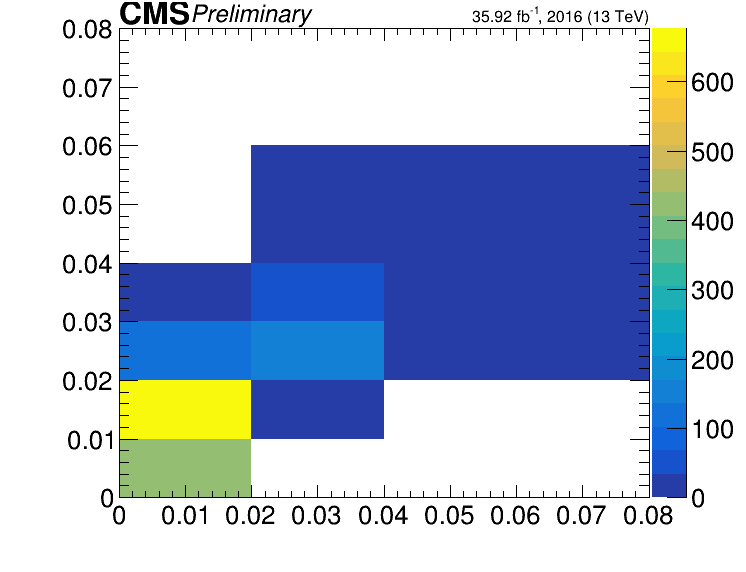

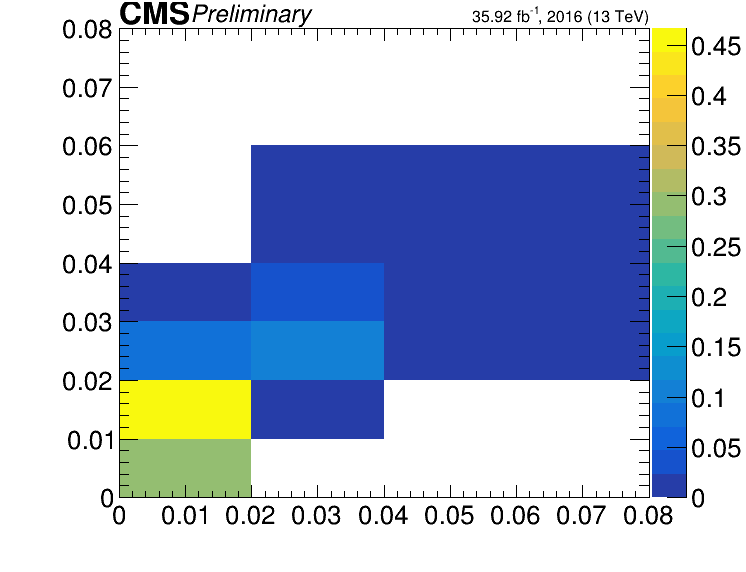

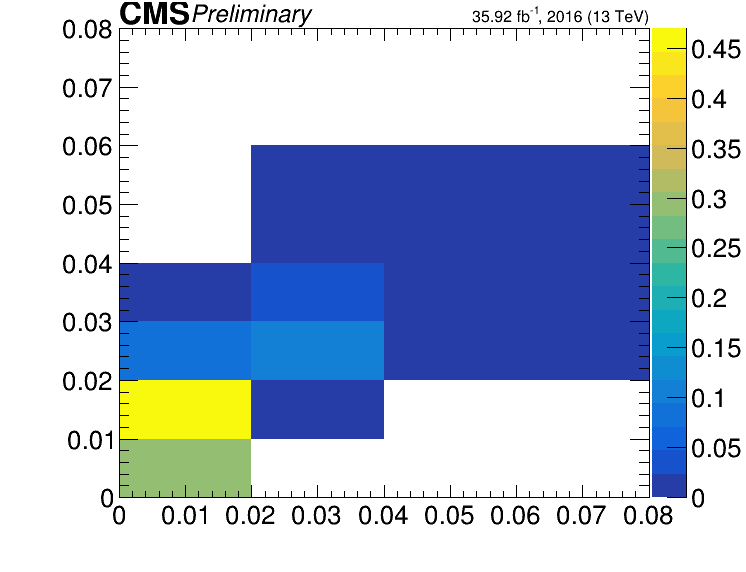

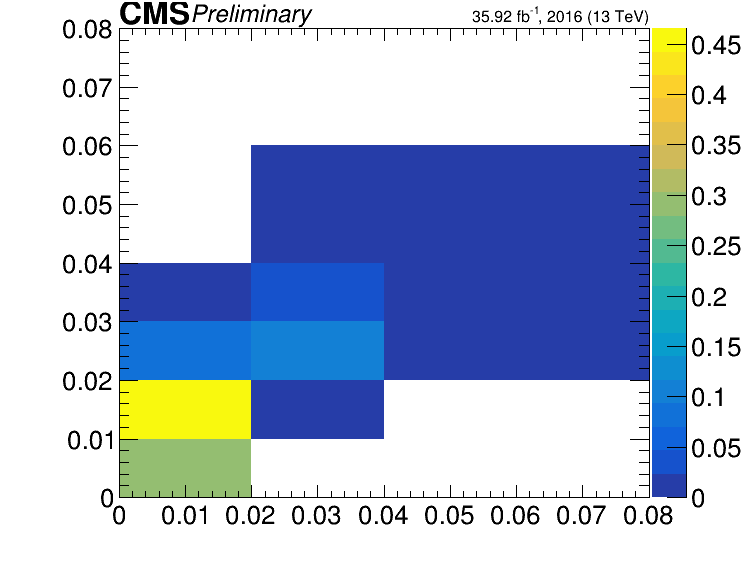

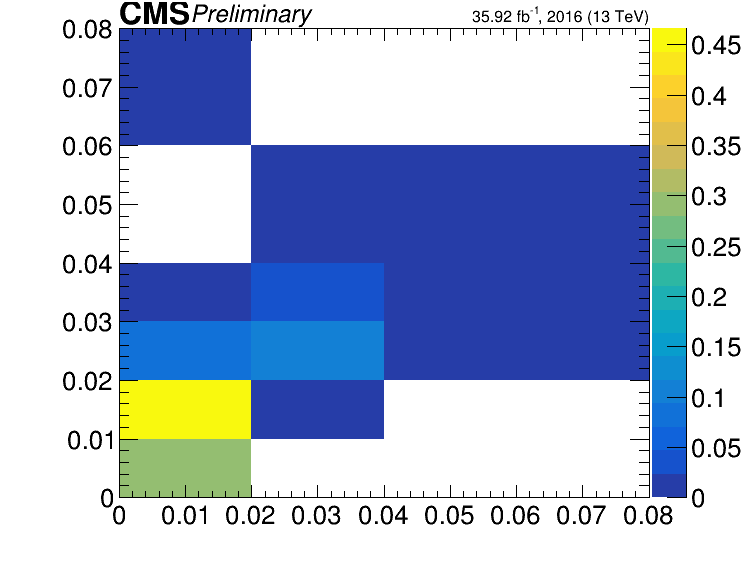

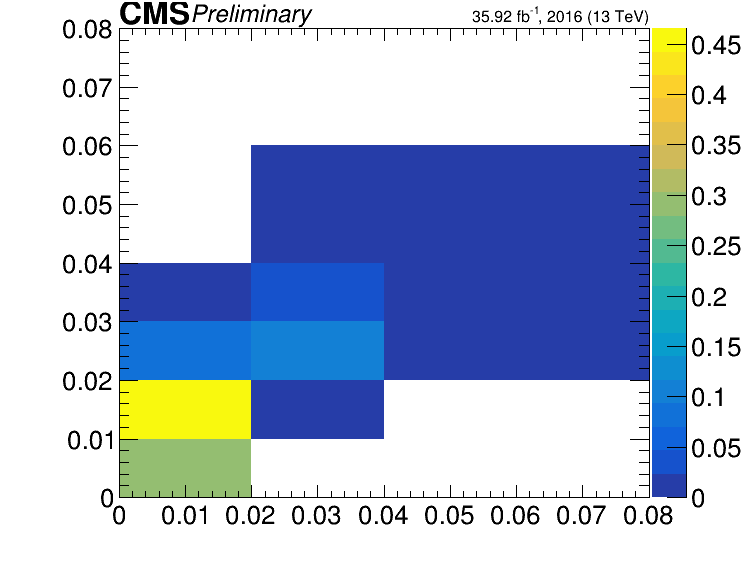

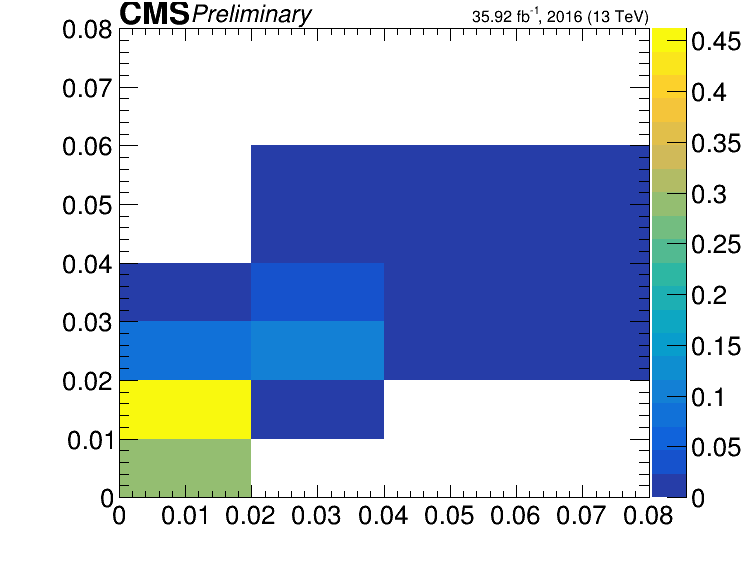

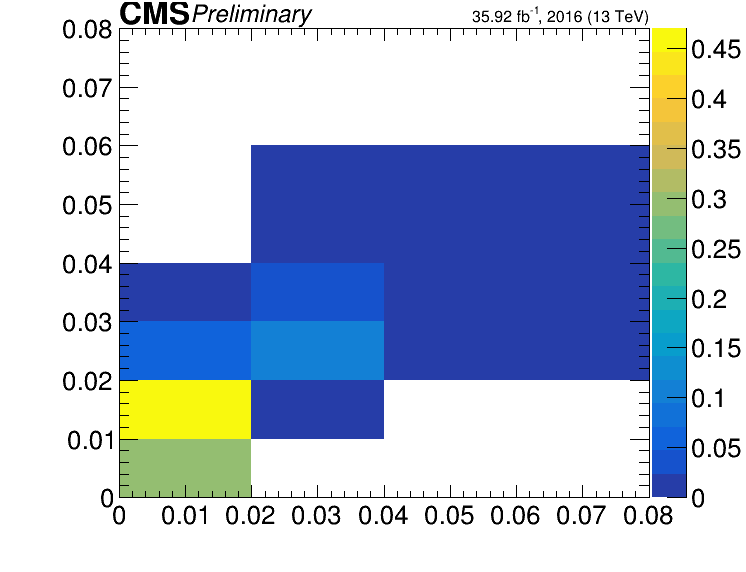

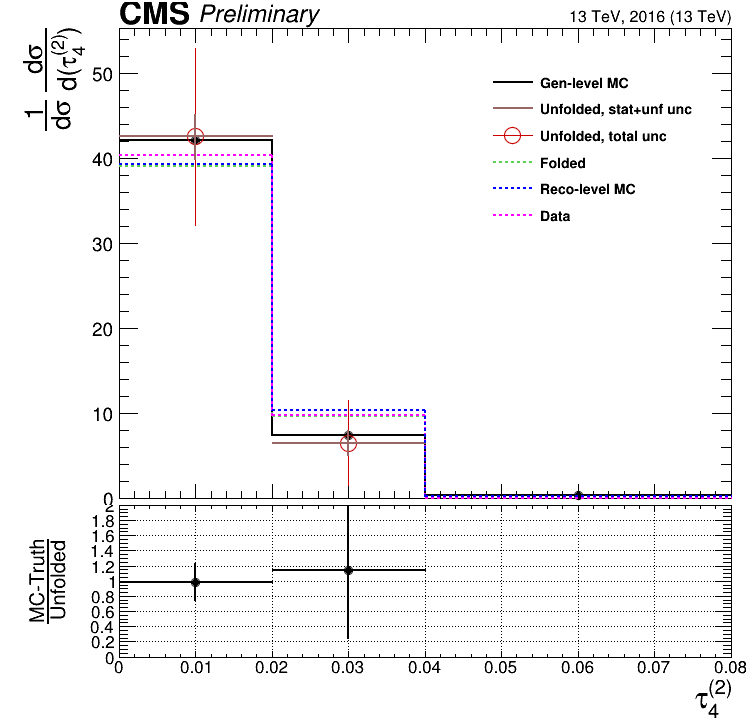

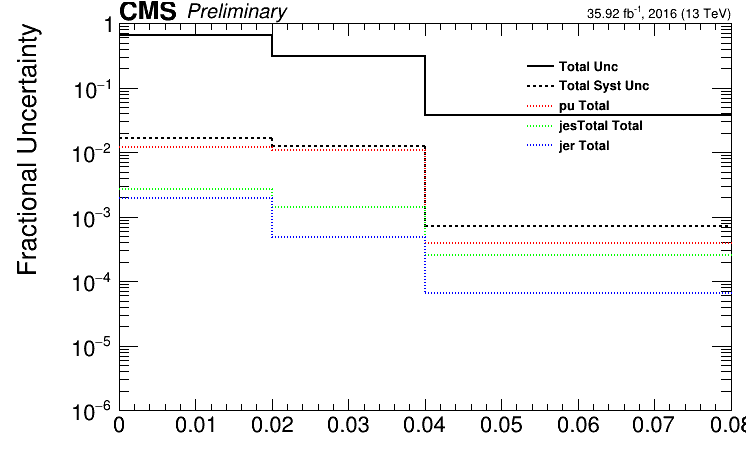

In [27]:
for ivar in variables:
    
    print '|------> Unfolding '+ivar

    ######## Cross check: plotting data vs all MC Scaled
    print '|------> Cross check: plotting data vs all MC'
    allBkgHisto = dataHistos['data_recoJet'+ivar+'_nom'+sel].Clone()
    allBkgHisto.Reset()
    allBkgHistoNorm = allBkgHisto.Clone()
    allBkgHistoGenBin = dataHistos['data_recoJet'+ivar+'_nom'+sel+'_genBin'].Clone()
    allBkgHistoGenBin.Reset()
    for ibkg in bkgHistos:
        if ibkg.endswith('_recoJet'+ivar+'_nom'+sel): allBkgHisto.Add( bkgHistos[ibkg].Clone() )
        if ibkg.endswith('_recoJet'+ivar+'_nom'+sel+'_genBin'): allBkgHistoGenBin.Add( bkgHistos[ibkg].Clone() )
        if ibkg.endswith('_recoJet'+ivar+'_nom'+sel+'_Normalized'): allBkgHistoNorm.Add( bkgHistos[ibkg].Clone() )
    allMCHisto = allBkgHisto.Clone()
    allMCHisto.Add( signalHistos[ next(iter(sigFiles))+'_recoJet'+ivar+'_nom'+sel ].Clone() )
    plotSimpleComparison( dataHistos['data_recoJet'+ivar+'_nom'+sel].Clone(), 'data', allMCHisto, 'allBkgs', ivar+'_from'+('Data' if process.startswith('data') else 'MC')+'_'+next(iter(sigFiles))+"_nom", rebinX=variables[ivar][0], version=sel+'_'+version  )
    allMCHistoNorm = allBkgHistoNorm.Clone()
    allMCHistoNorm.Add( signalHistos[ next(iter(sigFiles))+'_recoJet'+ivar+'_nom'+sel+"_Normalized" ].Clone() )
    plotSimpleComparison( dataHistos['data_recoJet'+ivar+'_nom'+sel+"_Normalized"].Clone(), 'data', allMCHistoNorm, 'allBkgs', ivar+'_from'+('Data' if process.startswith('data') else 'MC')+'_'+next(iter(sigFiles))+"_nom_Normalized", rebinX=variables[ivar][0], version=sel+'_'+version  )

    ######## Cross check: plotting response matrix
    #tdrStyle.SetPadRightMargin(0.12)
    print '|------> Cross check: plotting response matrix for signal'
    can2D = ROOT.TCanvas(ivar+'can2D', ivar+'can2D', 750,600 )
    signalHistos[next(iter(sigFiles))+'_respJet'+ivar+'_nom'+sel].SetStats(0)
    signalHistos[next(iter(sigFiles))+'_respJet'+ivar+'_nom'+sel].Draw("colz")
    can2D.SetRightMargin(0.13)
    CMS_lumi.extraText = "  Preliminary"
    CMS_lumi.lumi_13TeV = str( round( (lumi/1000.), 2 ) )+" fb^{-1}, 2016"
    #CMS_lumi.lumi_13TeV = "13 TeV, 2016"
    CMS_lumi.relPosX = 0.11
    CMS_lumi.CMS_lumi(can2D, 4, 0)
    can2D.Draw()
    can2D.SaveAs('Plots/'+ivar+'_from'+('Data' if process.startswith('data') else 'MC')+'_'+next(iter(sigFiles))+sel+'_responseMatrix'+version+'.png')
    can2DNorm = ROOT.TCanvas(ivar+'can2DNorm', ivar+'can2DNorm', 750, 600 )
    signalHistos[next(iter(sigFiles))+'_respJet'+ivar+'_nom'+sel+'_Normalized'].SetStats(0)
    signalHistos[next(iter(sigFiles))+'_respJet'+ivar+'_nom'+sel+'_Normalized'].Draw("colz")
    can2DNorm.SetRightMargin(0.13)
    CMS_lumi.extraText = "  Preliminary"
    CMS_lumi.lumi_13TeV = str( round( (lumi/1000.), 2 ) )+" fb^{-1}, 2016"
    #CMS_lumi.lumi_13TeV = "13 TeV, 2016"
    CMS_lumi.relPosX = 0.11
    CMS_lumi.CMS_lumi(can2DNorm, 4, 0)
    can2DNorm.Draw()
    can2DNorm.SaveAs('Plots/'+ivar+'_from'+('Data' if process.startswith('data') else 'MC')+'_'+next(iter(sigFiles))+sel+'Normalized_responseMatrix'+version+'.png')

    ####### Removing bkgs from data
    dataMinusBkgs = dataHistos[ 'data_recoJet'+ivar+'_nom'+sel ].Clone()
    dataMinusBkgs.Add( allBkgHisto.Clone(), -1 )
    dataMinusBkgs.Scale( 1/dataMinusBkgs.Integral() )
    dataMinusBkgsGenBin = dataHistos[ 'data_recoJet'+ivar+'_nom'+sel+'_genBin' ].Clone()
    dataMinusBkgsGenBin.Add( allBkgHistoGenBin.Clone(), -1 )
    dataMinusBkgsGenBin.Scale( 1/dataMinusBkgsGenBin.Integral() )

    ######## TUnfold part
    print '|------> TUnfolding starts:'

    ##### Defining options for TUnfold
    tunfolder = ROOT.TUnfoldDensity(
                                        signalHistos[next(iter(sigFiles))+'_respJet'+ivar+'_nom'+sel+'_Normalized'], ### response matrix
                                        #signalHistos[next(iter(sigFiles))+'_respJet'+ivar+'_nom'+sel], ### response matrix
                                        ROOT.TUnfold.kHistMapOutputHoriz,  #### kHistMapOutputVert if x->reco and y->gen, kHistMapOutputHoriz if x->gen and y->reco
                                        ROOT.TUnfold.kRegModeCurvature,   ##### Regularization Mode : ROOT.TUnfold.kRegModeCurvature regularizes based on the 2nd derivative of the output. More information wrt the other options can be gained from reading the source code
                                        ROOT.TUnfold.kEConstraintNone,    ##### Constraint : TUnfold.kEConstraintNone meaning we do not constrain further, the other option is to force constraint of area. (Need to look into this!!)
                                        ROOT.TUnfoldDensity.kDensityModeBinWidth  ##### Density Mode: ROOT.TUnfoldDensity.kDensityModeBinWidth uses the bin width to normalize the event rate in a given bin, accounting for non-uniformity in bin widths as discussed in section 7.2.1 of the TUnfold paper
                                        )

    ##### Defining input (data recoJet )
    print '|------> TUnfolding adding input:'
    #tunfolder.SetInput( dataHistos[ 'data_recoJet'+ivar+'_nom'+sel ].Clone() )
    tunfolder.SetInput( dataMinusBkgs )

    ###### Removing bkgs from data using TUnfold. Better to subtract bkgs beforehand
    #for ibkg in bkgHistos:
    #    if ibkg.endswith('_recoJet'+ivar+'_nom'+sel+'_Normalized'):
    #        print '|--------> Removing this bkg: ', ibkg
    #        tunfolder.SubtractBackground( bkgHistos[ibkg], ibkg )

    ###### Adding SYS unc
    if len(sysUncert)>0 :
        print '|------> TUnfolding adding uncert:'
        for sys in sysUncert:
            #plotSysComparison( signalHistos[next(iter(sigFiles))+'_recoJet'+ivar+'_nom'+sel+"_Normalized"],
            #                    signalHistos[next(iter(sigFiles))+'_recoJet'+ivar+sys+'Up'+sel+"_Normalized"],
            #                    signalHistos[next(iter(sigFiles))+'_recoJet'+ivar+sys+'Down'+sel+"_Normalized"],
            #                    ivar+'_'+next(iter(sigFiles)),
            #                    sys.split('_')[1],
            #                    version=sel+'_'+version
            #                    )
            for upDown in [ 'Up', 'Down' ]:
                print sys+upDown
                tunfolder.AddSysError(
                                    signalHistos[next(iter(sigFiles))+'_respJet'+ivar+sys+upDown+sel+"_Normalized"],
                                    sys+upDown,
                                    ROOT.TUnfold.kHistMapOutputHoriz,
                                    ROOT.TUnfoldSys.kSysErrModeMatrix, #### kSysErrModeMatrix the histogram sysError corresponds to an alternative response matrix. kSysErrModeShift the content of the histogram sysError are the absolute shifts of the response matrix. kSysErrModeRelative the content of the histogram sysError specifies the relative uncertainties
                                    )
                can2DNorm = ROOT.TCanvas(ivar+'can2DNorm'+sys+upDown, ivar+'can2DNorm'+sys+upDown, 750, 600 )
                signalHistos[next(iter(sigFiles))+'_respJet'+ivar+sys+upDown+sel+"_Normalized"].SetStats(0)
                signalHistos[next(iter(sigFiles))+'_respJet'+ivar+sys+upDown+sel+"_Normalized"].Draw("colz")
                can2DNorm.SetRightMargin(0.13)
                CMS_lumi.extraText = "  Preliminary"
                CMS_lumi.lumi_13TeV = str( round( (lumi/1000.), 2 ) )+" fb^{-1}, 2016"
                #CMS_lumi.lumi_13TeV = "13 TeV, 2016"
                CMS_lumi.relPosX = 0.11
                CMS_lumi.CMS_lumi(can2DNorm, 4, 0)
                can2DNorm.Draw()
                can2DNorm.SaveAs('Plots/'+ivar+'_from'+('Data' if process.startswith('data') else 'MC')+'_'+next(iter(sigFiles))+sel+sys+upDown+'Normalized_responseMatrix'+version+'.png')

    ###### Running the unfolding
    print '|------> TUnfolding doUnfold:'
    tunfolder.DoUnfold(0)

    ###### Regularization
#        nScan=50
#        tauMin=0.0
#        tauMax=0.0
#        iBest=0
#
#        logTauX = ROOT.MakeNullPointer(ROOT.TSpline)
#        logTauY = ROOT.MakeNullPointer(ROOT.TSpline)
#        lCurve = ROOT.MakeNullPointer(ROOT.ROOT.TGraph)
#        ## this method scans the parameter tau and finds the kink in the L curve finally, the unfolding is done for the best choice of tau
#        tunfolder.ScanLcurve(nScan,tauMin,tauMax,lCurve,logTauX,logTauY)
    #########################
    ROOT.gStyle.SetOptStat(0)

    ##### Get output of unfolding
    unfoldHisto = tunfolder.GetOutput("unfoldHisto")

    #### Get various covariances
    print '|------> TUnfolding covariances'
    cov = tunfolder.GetEmatrixTotal("cov", "Covariance Matrix")
    cov_uncorr = tunfolder.GetEmatrixSysUncorr("cov_uncorr", "Covariance Matrix from Uncorrelated Uncertainties")
    cov_uncorr_data = tunfolder.GetEmatrixInput("cov_uncorr_data", "Covariance Matrix from Stat Uncertainties of Input Data")
    unfoldHistowoUnc = unfoldHisto.Clone()        # Unfolding and stat unc
    unfoldHistoStatUnc = unfoldHisto.Clone("unfoldHistoStatUnc")        # Unfolding and stat unc
    unfoldHistoTotUnc = unfoldHisto.Clone("unfoldHistoTotUnc")          # Total uncertainty
    for ibin in range( 0, unfoldHisto.GetNbinsX()+1 ):
        unc_tot = ROOT.TMath.Sqrt( cov.GetBinContent(ibin,ibin) )
        unfoldHistoTotUnc.SetBinContent(ibin, unc_tot )
        unfoldHisto.SetBinError(ibin, unc_tot )


    ##### Get systematic shifts of output
    uncerUnfoldHisto = {}
    if len(sysUncert)>0 :
        print '|------> TUnfolding uncertainties:'
        unfoldHistoSysUnc = unfoldHisto.Clone("unfoldHistoSysUnc")          # Syst uncertainty
        unfoldHistoSysUnc.Reset()
        unfoldHistoSysUnc.SetLineStyle(2)

        for sys in sysUncert:
            for upDown in [ 'Up', 'Down' ]:
                print sys+upDown
                uncerUnfoldHisto[ivar+sys+upDown] = tunfolder.GetDeltaSysSource(sys+upDown, "unfoldHisto_"+sys+upDown+"shift", "-1#sigma")
                try: uncerUnfoldHisto[ivar+sys+upDown].SetLineStyle(2)
                except ReferenceError: uncerUnfoldHisto.pop( ivar+sys+upDown, None )

            # Create total uncertainty and sys uncertainty plots.
            uncerUnfoldHisto[ivar+sys+'Total'] = unfoldHisto.Clone("unfoldHistoSysUnc")          # Syst uncertainty
            uncerUnfoldHisto[ivar+sys+'Total'].Reset()
            uncerUnfoldHisto[ivar+sys+'Total'].SetLineStyle(3)
            for i in xrange( 0, unfoldHisto.GetNbinsX() + 1):
                try: yup = abs( uncerUnfoldHisto[ivar+sys+'Up'].GetBinContent(i))
                except KeyError: yup = 0
                try: ydn = abs( uncerUnfoldHisto[ivar+sys+'Down'].GetBinContent(i))
                except KeyError: ydn = 0
                dy = ROOT.TMath.Sqrt( (yup**2 + ydn**2) )
                uncerUnfoldHisto[ivar+sys+'Total'].SetBinContent(i, dy )
            unfoldHistoSysUnc.Add( uncerUnfoldHisto[ivar+sys+'Total'] )

    ###### Plot unfolding results
    #tdrStyle.SetPadRightMargin(0.05)
    #tdrStyle.SetPadLeftMargin(0.15)
    can = ROOT.TCanvas('can', 'can',  10, 10, 750, 750 )
    pad1 = ROOT.TPad("pad1", "Main",0,0.207,1.00,1.00,-1)
    pad2 = ROOT.TPad("pad2", "Ratio",0,0.00,1.00,0.30,-1);
    pad1.Draw()
    pad2.Draw()
    #ROOT.gStyle.SetOptStat(0)

    pad1.cd()
    
    #tmpPad1 = pad1.DrawFrame( 0, 0.3, 1, 1.7 )
    
    #tmpPad1.GetYaxis().SetTitle( '#frac{1}{d#sigma} #frac{d#sigma}{d(#tau_{4}^{(2)})}' )
    #tmpPad1.GetYaxis().SetTitleOffset(0.9)
    #tmpPad1.GetYaxis().SetTitleSize(28)
    #tmpPad1.GetYaxis().SetLabelSize(20)
    #tmpPad1.SetStats(0)
    
    leg=ROOT.TLegend(0.65,0.6,0.95,0.88)
    leg.SetLineColor(0)
    leg.SetLineWidth(0)
    leg.SetBorderSize(0)
    leg.SetFillStyle(0)
    #leg.SetTextSize(0.8)

    #genJetHisto = signalHistos[ next(iter(sigFiles))+'_genJet'+ivar+sel ].Clone()
    genJetHisto = signalHistos[ next(iter(sigFiles))+'_genJet'+ivar+sel+'_Normalized' ].Clone()
    genJetHisto.GetYaxis().SetTitle( '#frac{1}{d#sigma} #frac{d#sigma}{d(#tau_{4}^{(2)})}' )
    genJetHisto.GetYaxis().SetTitleSize( 0.05 )
    genJetHisto.GetYaxis().SetTitleOffset( 1.1 )
    #genJetHisto.GetYaxis().CenterTitle()
    genJetHisto.SetStats(0)
    genJetHisto.Scale(1, 'width')  ### divide by bin width
    genJetHisto.SetLineWidth(2)
    genJetHisto.GetYaxis().SetLabelSize(0.037)
    genJetHisto.SetLineColor(1)
    pad1.Modified()
    pad1.Update()

    leg.AddEntry( genJetHisto, 'Gen-level MC', 'l' )

    #unfoldHisto = tunfolder.GetOutput("unfolded")
    #if len(variables[ivar])>1: unfoldHisto = unfoldHisto.Rebin( len(variables[ivar])-1, unfoldHisto.GetName()+"_rebin", array( 'd', variables[ivar] ) )
    #else: unfoldHisto.Rebin( variables[ivar][0] )
    

    unfoldHistowoUnc.Scale(1, 'width')  ### divide by bin width
    unfoldHistowoUnc.SetMarkerStyle(0)
    unfoldHistowoUnc.SetMarkerColor(ROOT.kRed-5)
    unfoldHistowoUnc.SetLineColor(ROOT.kRed-5)
    unfoldHistowoUnc.SetLineWidth(2)
    unfoldHistowoUnc.SetStats(0)
    leg.AddEntry( unfoldHistowoUnc, 'Unfolded, stat+unf unc', 'l' )
    
    unfoldHisto.Scale(1, 'width')  ### divide by bin width
    unfoldHisto.SetMarkerStyle(4)
    unfoldHisto.SetMarkerSize(2)
    unfoldHisto.SetMarkerColor(ROOT.kRed+1)
    unfoldHisto.SetLineColor(ROOT.kRed+1)
    unfoldHisto.SetStats(0)
    leg.AddEntry( unfoldHisto, 'Unfolded, total unc', 'pl' )

    foldHisto = tunfolder.GetFoldedOutput("folded") #, 'folded', 'folded', , False)
    if len(variables[ivar])>1: foldHisto = foldHisto.Rebin( len(variables[ivar])-1, foldHisto.GetName()+"_rebin", array( 'd', variables[ivar] ) )
    else: foldHisto.Rebin( 2 )
    foldHisto.Scale(1, 'width')  ### divide by bin width
    foldHisto.SetLineWidth(2)
    foldHisto.SetLineStyle(2)
    foldHisto.SetLineColor(8)
    foldHisto.SetStats(0)
    leg.AddEntry( foldHisto, 'Folded', 'l' )

    if process.startswith('data'):
        #recoJetHisto = signalHistos[ next(iter(sigFiles))+'_recoJet'+ivar+'_nom'+sel+'_Normalized' ].Clone()
        recoJetHisto = signalHistos[ next(iter(sigFiles))+'_recoJet'+ivar+'_nom'+sel+'_genBin' ].Clone()
        recoJetHisto.Scale(1/recoJetHisto.Integral(), 'width')  ### divide by bin width
        recoJetHisto.SetLineWidth(2)
        recoJetHisto.SetLineStyle(2)
        recoJetHisto.SetLineColor(ROOT.kBlue)
        leg.AddEntry( recoJetHisto, 'Reco-level MC', 'l' )

    dataJetHisto = dataMinusBkgsGenBin.Clone()
    dataJetHisto.Scale(1/dataJetHisto.Integral(), 'width')  ### divide by bin width
    dataJetHisto.SetLineWidth(2)
    dataJetHisto.SetLineStyle(2)
    dataJetHisto.SetLineColor(ROOT.kMagenta)
    dataJetHisto.SetStats(0)
    leg.AddEntry( dataJetHisto, ('Data' if process.startswith('data') else 'MC Closure' ), 'l' )

    
    
    genJetHisto.SetMaximum( 1.3*max([ genJetHisto.GetMaximum(), unfoldHisto.GetMaximum(), unfoldHistowoUnc.GetMaximum(), dataJetHisto.GetMaximum() ] )  )
    pad1.Update()
    pad1.Modified()
    
    genJetHisto.Draw( "histe")
    unfoldHisto.Draw( "same")
    unfoldHistowoUnc.Draw( "e1 same")
    foldHisto.Draw( "hist same")
    dataJetHisto.Draw( "hist same")
    if process.startswith('data'): recoJetHisto.Draw( "hist same")
    #ROOT.gStyle.SetOptStat(0)
    leg.Draw()
    CMS_lumi.extraText = "Preliminary"
    CMS_lumi.cmsTextSize = 1.2
    #CMS_lumi.lumi_13TeV = str( round( (lumi/1000.), 2 ) )+" fb^{-1}, 13 TeV, 2016"
    CMS_lumi.lumi_13TeV = "13 TeV, 2016"
    CMS_lumi.cmsTextSize = 1.2
    CMS_lumi.relPosX = 0.13
    CMS_lumi.CMS_lumi(pad1, 4, 0)

    pad2.cd()
    ROOT.gStyle.SetOptFit(1)
    ROOT.gStyle.SetOptStat(0000000)
    pad2.SetGrid()
    pad2.SetTopMargin(0)
    pad2.SetBottomMargin(0.3)
    #tmpPad2= pad2.DrawFrame( 0, 0.5, 1, 1. )
    
    hRatioUp = genJetHisto.Clone()
    hRatioUp.GetYaxis().SetTitle( "#frac{MC-Truth}{Unfolded}" )
    hRatioUp.GetYaxis().SetTitleOffset( 0.6)
    hRatioUp.GetYaxis().SetTitleSize(0.1)
    hRatioUp.GetYaxis().SetLabelSize(0.085)
    hRatioUp.GetXaxis().SetTitle("#tau_{4}^{(2)}")
    hRatioUp.GetXaxis().SetTitleOffset( 0.8)
    hRatioUp.GetXaxis().SetTitleSize( 0.15)
    hRatioUp.GetXaxis().SetLabelSize(0.085)
    hRatioUp.GetYaxis().CenterTitle()
    hRatioUp.Divide( unfoldHisto )
    hRatioUp.GetYaxis().SetRangeUser(0.,2.)
    hRatioUp.Draw('P0')
    
    #tmpPad2.SetLabelSize(16, 'x')
    #tmpPad2.SetTitleSize(19, 'x')
    #tmpPad2.SetLabelSize(16., 'y')
    #tmpPad2.SetTitleSize(19., 'y')
    #tmpPad2.SetNdivisions(505, 'x')
    #tmpPad2.SetNdivisions(505, 'y')
    #tmpPad2.SetMarkerStyle(8)
    #hRatioUp.SetTitle("#tau_{4}^{(2)}")
    #hRatioUp.SetLabelSize(18)
    
    #hRatioUp.GetXaxis().SetTitle( genJetHisto.GetXaxis().GetTitle() )
    pad2.Modified()

    #pad2.Update()
    #pad2.Modified()
    #hRatioDown.Draw('P same')
    #pad1.cd()
    #leg.Draw()
    #can.Update()
    #can.Modified()
    can.Draw()
    can.SaveAs('Plots/'+ivar+sel+'_from'+('Data' if process.startswith('data') else 'MC')+(''.join(sysUncert))+'_Tunfold_'+version+'.png')

    canUnc = ROOT.TCanvas('canUnc', 'canUnc',  10, 10, 750, 500 )
    canUnc.SetTitle("")
    #canUnc.SetLogy()
    #ROOT.gStyle.SetOptStat(0)
    legend=ROOT.TLegend(0.70,0.67,0.90,0.88)
    legend.SetFillStyle(0)
    legend.SetTextSize(0.03)
    legend.SetBorderSize(0)
    legend.SetLineStyle(0)
    legend.AddEntry( unfoldHistoTotUnc, 'Total Unc', 'l' )

    unfoldHistoTotUnc.SetStats(0)
    unfoldHistoTotUnc.SetLineWidth(2)
    unfoldHistoTotUnc.Scale( 1/(unfoldHistoTotUnc.Integral()) )
    unfoldHistoTotUnc.SetMaximum(1.)
    unfoldHistoTotUnc.SetMinimum(0.000001)
    unfoldHistoTotUnc.GetYaxis().SetTitle('Fractional Uncertainty')
    unfoldHistoTotUnc.Draw('hist')

    if len(sysUncert)>0 :
        legend.AddEntry( unfoldHistoSysUnc, 'Total Syst Unc', 'l' )
        unfoldHistoSysUnc.Scale( 1/unfoldHistoTotUnc.Integral() )
        unfoldHistoSysUnc.SetLineWidth(2)
        unfoldHistoSysUnc.SetStats(0)
        unfoldHistoSysUnc.Draw("hist same")
        dummy=2
        for k in uncerUnfoldHisto:
            if k.endswith('Total'):
                for i in sysUncert:
                    if i in k:
                        legend.AddEntry( uncerUnfoldHisto[k], i.split('_')[1]+" Total", 'l' )
                uncerUnfoldHisto[k].SetLineColor(dummy)
                uncerUnfoldHisto[k].SetLineWidth(2)
                uncerUnfoldHisto[k].SetStats(0)
                uncerUnfoldHisto[k].Scale( 1/unfoldHistoTotUnc.Integral() )
                uncerUnfoldHisto[k].Draw("hist same")
                dummy=dummy+1

    legend.Draw()
    CMS_lumi.extraText = "Preliminary"
    CMS_lumi.lumi_13TeV = str( round( (lumi/1000.), 2 ) )+" fb^{-1}, 2016"
    #CMS_lumi.lumi_13TeV = "2016"
    ROOT.gPad.SetLogy()
    CMS_lumi.relPosX = 0.11
    CMS_lumi.CMS_lumi(canUnc, 4, 0)
    canUnc.Draw()
    canUnc.SaveAs('Plots/'+ivar+sel+'_from'+('Data' if process.startswith('data') else 'MC')+(''.join(sysUncert))+'_Tunfold_UNC_'+version+'.png')
